In [5]:
DATAPATH = '/home/local/FARFETCH/tiagosouza.oliveira/Documents/datasets/kdm-porto-2019/train.csv'
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime, date
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress

%matplotlib inline
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


In [2]:
data = pd.read_csv(DATAPATH, sep=',')
data_hour = pd.read_csv(DATAPATH, sep=',')

In [3]:
data.head()


interval  total_calls  total_calls_duration  missing_calls  \
0  2017-01-01 00:00:00          227                 11880              8   
1  2017-01-01 00:15:00          235                 15297              4   
2  2017-01-01 00:30:00          219                 13739              5   
3  2017-01-01 00:45:00          256                 16534              5   
4  2017-01-01 01:00:00          240                 17692             14   

   available_time  away_time  busy_time  on_a_call_time  after_call_work_time  \
0            9721      28806          0           14047                  4543   
1           10716      34697          0           16636                  4932   
2           16380      24186          0           16092                  6280   
3            8086      12307          0           16253                  5932   
4            8371      25296          0           18225                  7217   

   total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
0              18590       49.566679         32.547228       50.433321   
1              21568       48.198743         32.200176       51.801257   
2              22372       61.571705         35.546093       38.428295   
3              22185       71.095401         52.104373       28.904599   
4              25442       57.204487         43.042515       42.795513   

   agent_headcount  
0               56  
1               60  
2               61  
3               57  
4               61

In [4]:
#data.plot.hist()
data.describe()
#https://studylib.net/doc/25268801/pandas-cheat-sheet

total_calls  total_calls_duration  missing_calls  available_time  \
count  67104.000000          6.710400e+04   67104.000000    6.710400e+04   
mean     201.687530          2.289175e+04       2.373718    2.100571e+04   
std      192.385241          3.399462e+04       4.445029    4.862529e+04   
min        0.000000          0.000000e+00       0.000000    0.000000e+00   
25%       26.000000          2.060000e+03       0.000000    4.424750e+03   
50%      160.000000          1.489250e+04       1.000000    1.531100e+04   
75%      332.000000          3.689625e+04       3.000000    2.959625e+04   
max     7199.000000          3.631243e+06     325.000000    9.853390e+06   

          away_time     busy_time  on_a_call_time  after_call_work_time  \
count  6.710400e+04  6.710400e+04    6.710400e+04          6.710400e+04   
mean   2.628485e+04  1.839408e+04    2.274368e+04          5.469867e+03   
std    3.863404e+04  3.548265e+04    2.993716e+04          1.303530e+04   
min    0.000000e+00  0.000000e+00    0.000000e+00          0.000000e+00   
25%    2.218000e+03  0.000000e+00    1.870000e+03          4.730000e+02   
50%    1.692050e+04  0.000000e+00    1.534000e+04          3.782000e+03   
75%    3.379850e+04  2.184900e+04    3.794325e+04          8.019000e+03   
max    1.144860e+06  1.665431e+06    2.483933e+06          2.238978e+06   

       total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
count       6.710400e+04    67104.000000      67104.000000    67104.000000   
mean        2.821355e+04       52.870837         26.648778       35.867539   
std         3.591314e+04       27.649855         17.097233       23.937980   
min         0.000000e+00        0.000000          0.000000        0.000000   
25%         2.468000e+03       36.820529         15.895618       17.796743   
50%         1.957900e+04       54.880799         27.957595       35.616922   
75%         4.649625e+04       73.846339         36.798536       55.218085   
max         2.503274e+06      100.000000        100.000000      100.000000   

       agent_headcount  
count     67104.000000  
mean         79.129799  
std          72.945244  
min           0.000000  
25%          13.000000  
50%          61.000000  
75%         130.000000  
max         347.000000


## Forecasting with time steps in Days interval using Facebook Prophet

In [14]:
data.shape

(67104, 14)

In [5]:
#dropping out NA columns and rows 
data.dropna(axis=1, how='all', inplace=True)
data.dropna(axis=0, how='all', inplace=True)

In [16]:
data.shape

(67104, 14)

In [17]:
data.head()

interval  total_calls  total_calls_duration  missing_calls  \
0  2017-01-01 00:00:00          227                 11880              8   
1  2017-01-01 00:15:00          235                 15297              4   
2  2017-01-01 00:30:00          219                 13739              5   
3  2017-01-01 00:45:00          256                 16534              5   
4  2017-01-01 01:00:00          240                 17692             14   

   available_time  away_time  busy_time  on_a_call_time  after_call_work_time  \
0            9721      28806          0           14047                  4543   
1           10716      34697          0           16636                  4932   
2           16380      24186          0           16092                  6280   
3            8086      12307          0           16253                  5932   
4            8371      25296          0           18225                  7217   

   total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
0              18590       49.566679         32.547228       50.433321   
1              21568       48.198743         32.200176       51.801257   
2              22372       61.571705         35.546093       38.428295   
3              22185       71.095401         52.104373       28.904599   
4              25442       57.204487         43.042515       42.795513   

   agent_headcount  
0               56  
1               60  
2               61  
3               57  
4               61

In [6]:
#Converting to datetime
data['interval'] = pd.to_datetime(data['interval'])

In [19]:
data.head()


interval  total_calls  total_calls_duration  missing_calls  \
0 2017-01-01 00:00:00          227                 11880              8   
1 2017-01-01 00:15:00          235                 15297              4   
2 2017-01-01 00:30:00          219                 13739              5   
3 2017-01-01 00:45:00          256                 16534              5   
4 2017-01-01 01:00:00          240                 17692             14   

   available_time  away_time  busy_time  on_a_call_time  after_call_work_time  \
0            9721      28806          0           14047                  4543   
1           10716      34697          0           16636                  4932   
2           16380      24186          0           16092                  6280   
3            8086      12307          0           16253                  5932   
4            8371      25296          0           18225                  7217   

   total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
0              18590       49.566679         32.547228       50.433321   
1              21568       48.198743         32.200176       51.801257   
2              22372       61.571705         35.546093       38.428295   
3              22185       71.095401         52.104373       28.904599   
4              25442       57.204487         43.042515       42.795513   

   agent_headcount  
0               56  
1               60  
2               61  
3               57  
4               61

In [7]:
#Setup . as decimal separating in numerical columns
for col in data.iloc[:,2:].columns:
    if data[col].dtypes == object:
        print(data[col])
        data[col] = data[col].str.replace(',', '.').astype('float')

In [21]:
data.head()


interval  total_calls  total_calls_duration  missing_calls  \
0 2017-01-01 00:00:00          227                 11880              8   
1 2017-01-01 00:15:00          235                 15297              4   
2 2017-01-01 00:30:00          219                 13739              5   
3 2017-01-01 00:45:00          256                 16534              5   
4 2017-01-01 01:00:00          240                 17692             14   

   available_time  away_time  busy_time  on_a_call_time  after_call_work_time  \
0            9721      28806          0           14047                  4543   
1           10716      34697          0           16636                  4932   
2           16380      24186          0           16092                  6280   
3            8086      12307          0           16253                  5932   
4            8371      25296          0           18225                  7217   

   total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
0              18590       49.566679         32.547228       50.433321   
1              21568       48.198743         32.200176       51.801257   
2              22372       61.571705         35.546093       38.428295   
3              22185       71.095401         52.104373       28.904599   
4              25442       57.204487         43.042515       42.795513   

   agent_headcount  
0               56  
1               60  
2               61  
3               57  
4               61

In [8]:
#check missing values
data.isna().sum() > 1

interval                False
total_calls             False
total_calls_duration    False
missing_calls           False
available_time          False
away_time               False
busy_time               False
on_a_call_time          False
after_call_work_time    False
total_handle_time       False
occupancy_rate          False
utilization_rate        False
shrinkage_rate          False
agent_headcount         False
dtype: bool

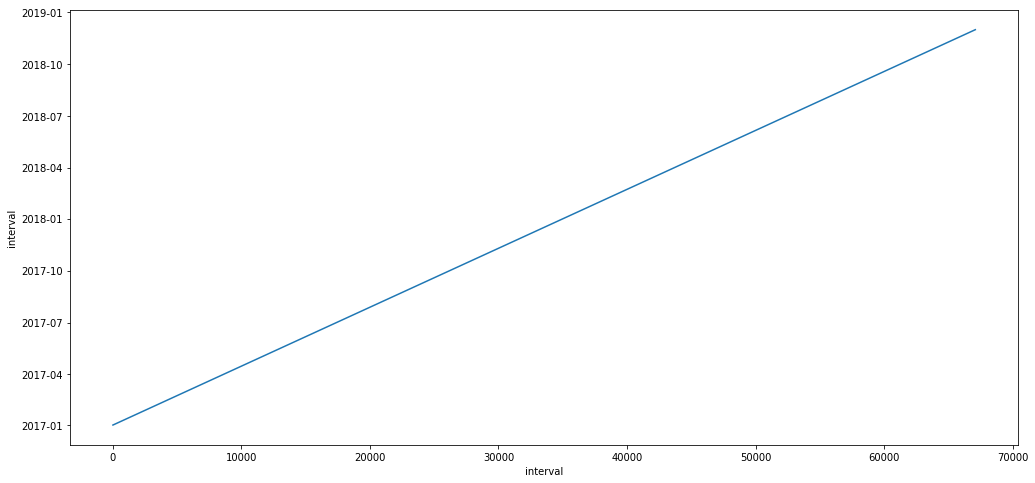

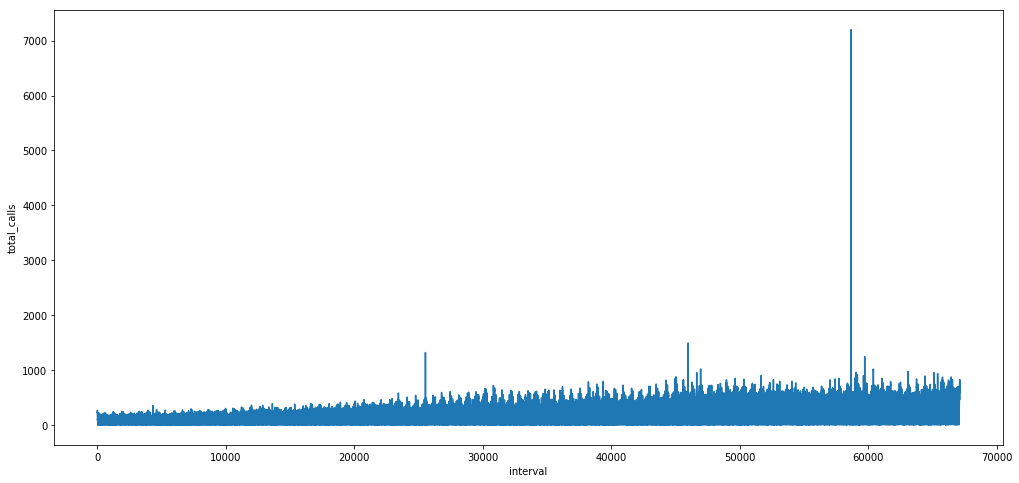

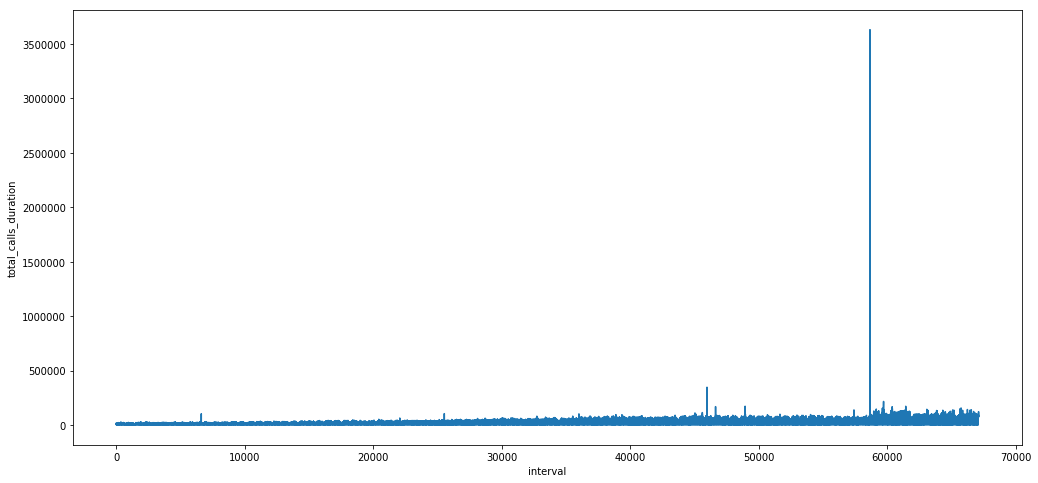

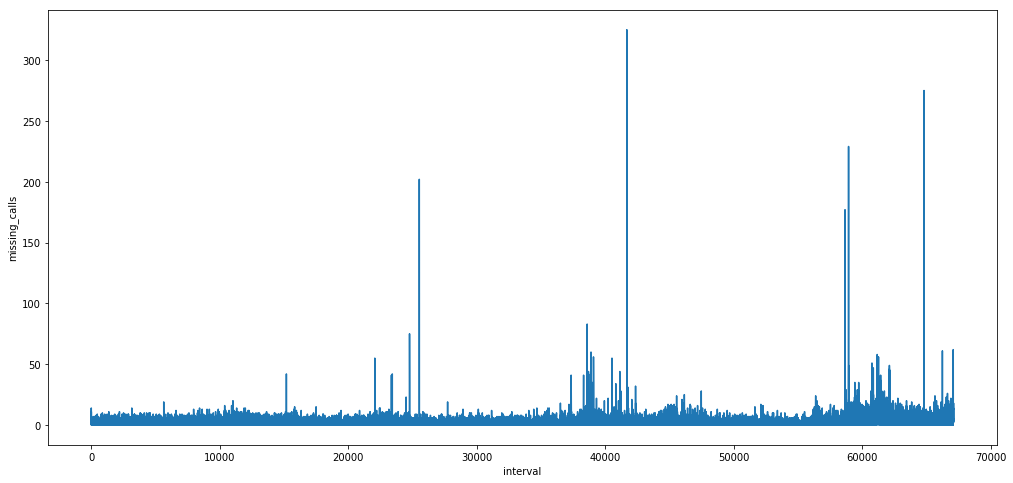

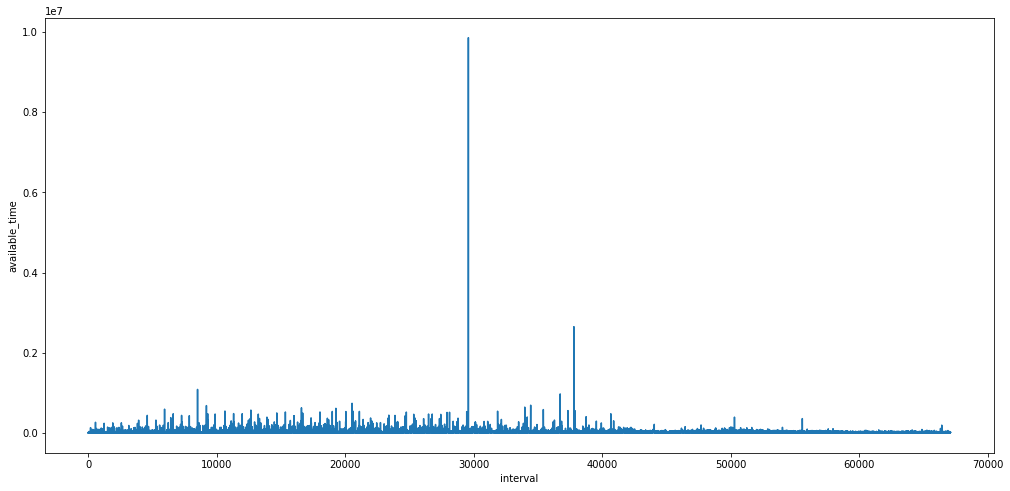

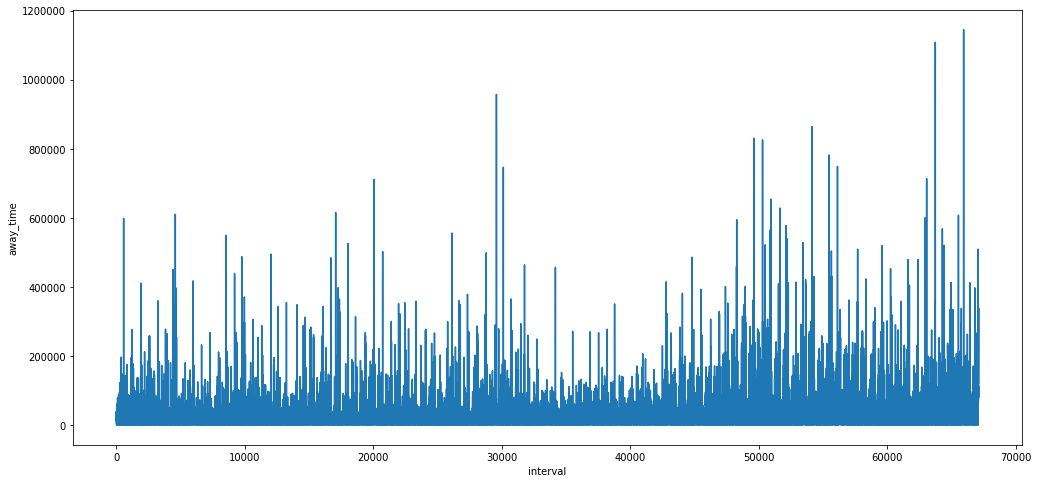

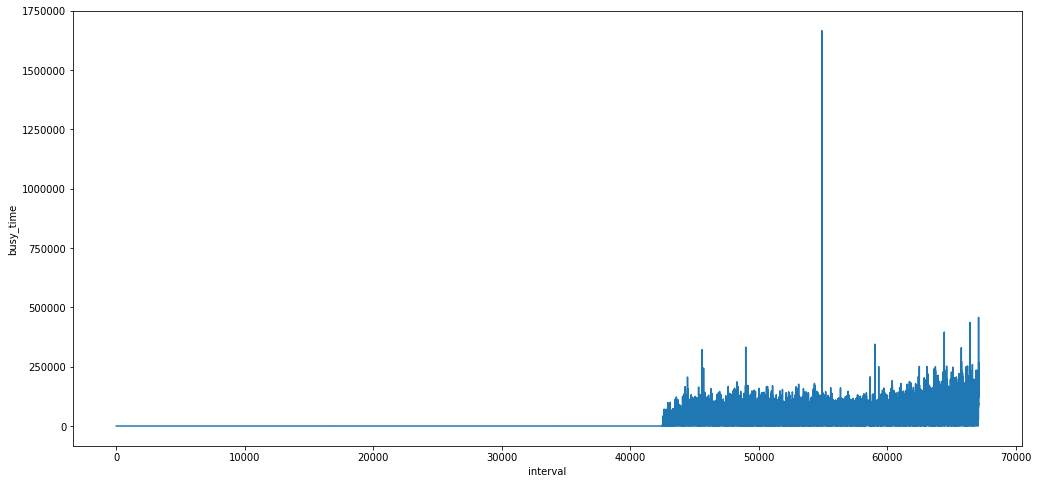

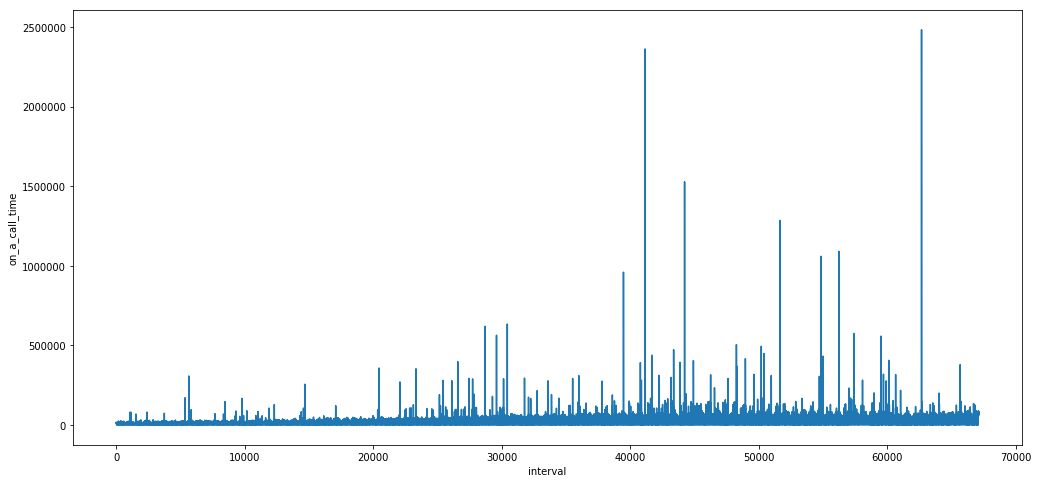

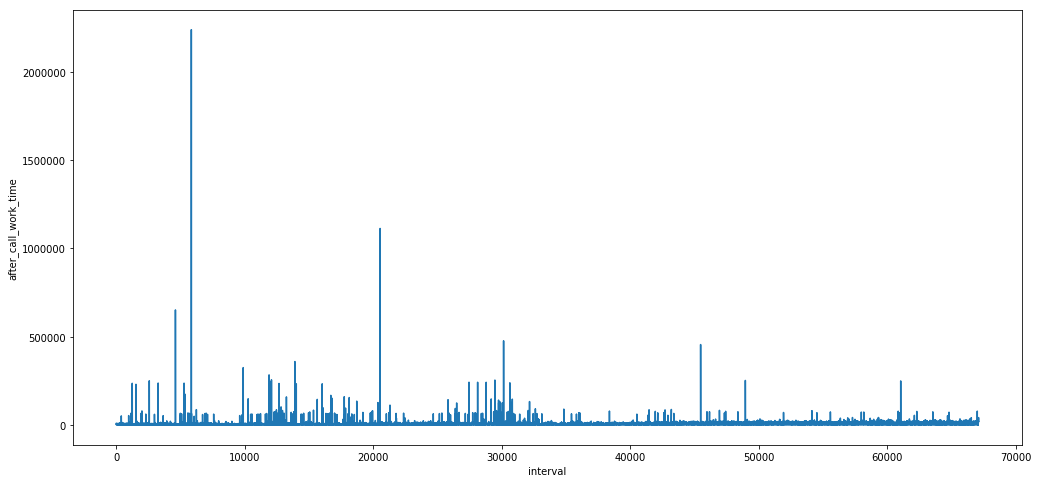

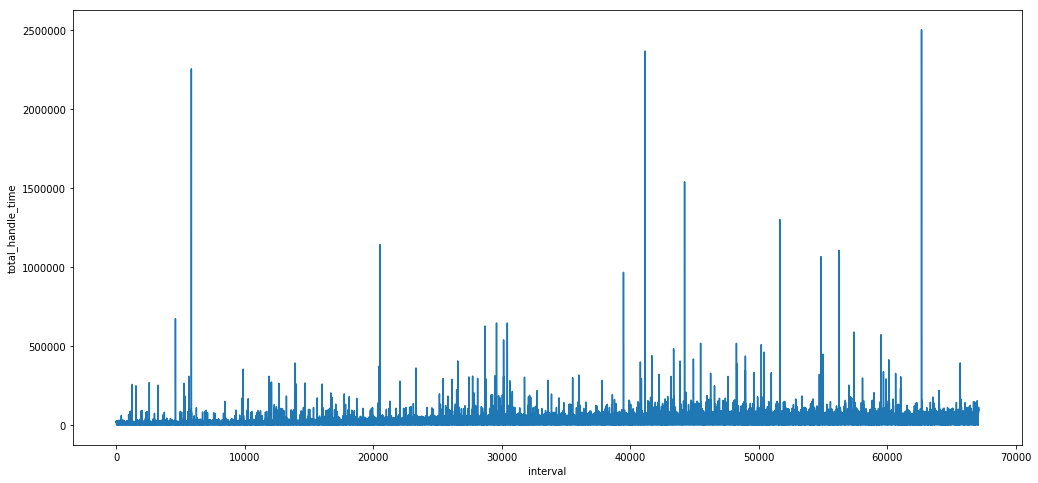

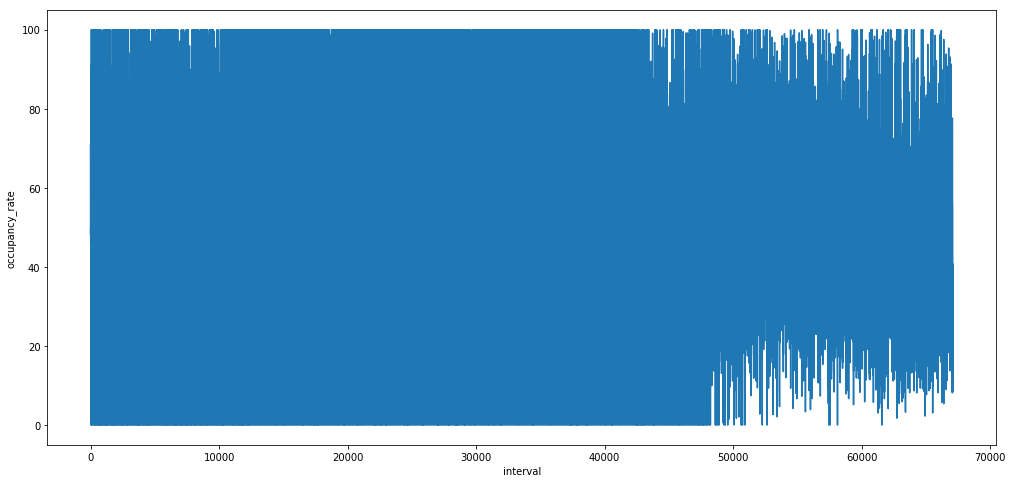

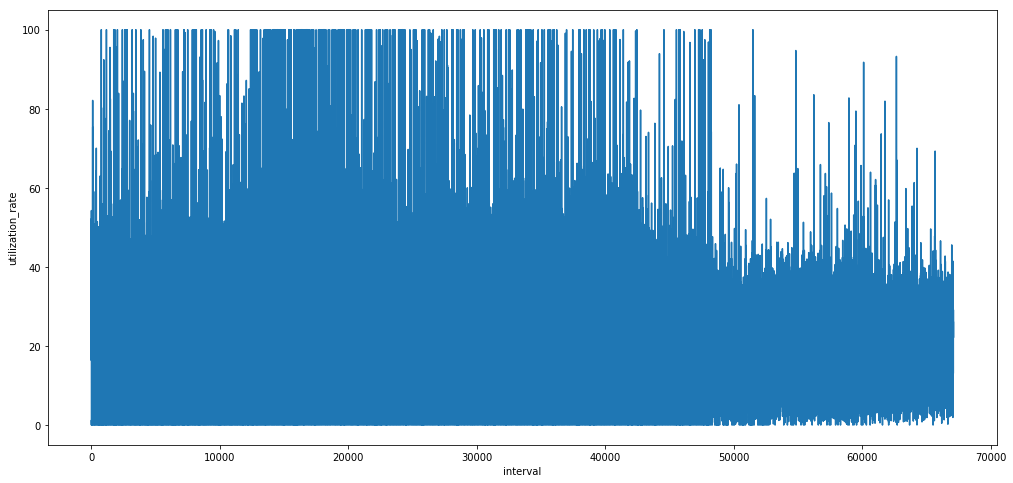

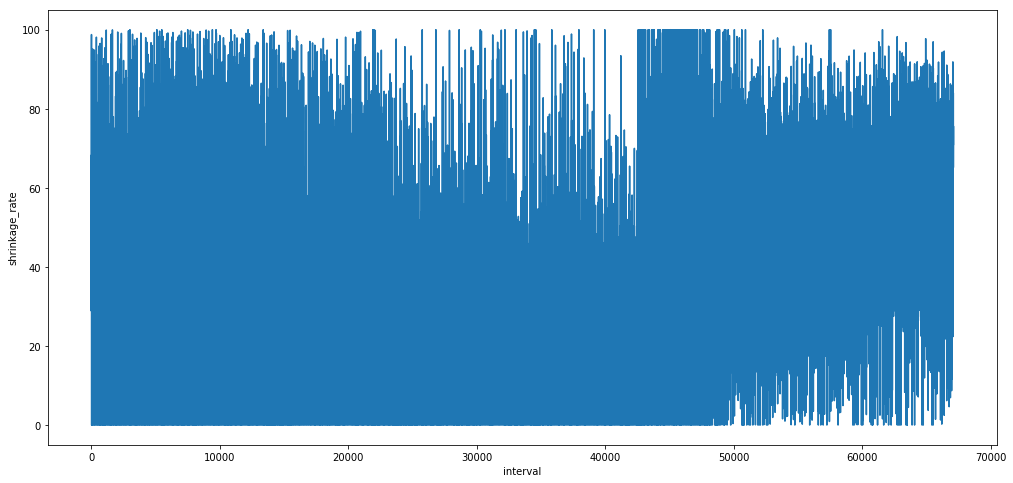

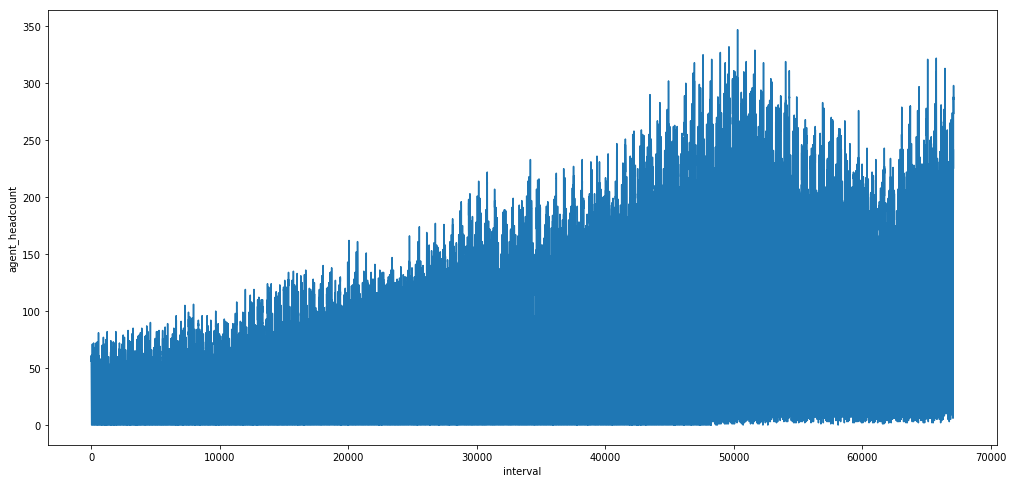

In [9]:
#Plot function
def plot_data(col, dt):
    plt.figure(figsize=(17, 8))
    plt.plot(dt[col])
    plt.xlabel('interval')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in data.columns:
    plot_data(col, data)

In [24]:
data['interval'].head()

0   2017-01-01 00:00:00
1   2017-01-01 00:15:00
2   2017-01-01 00:30:00
3   2017-01-01 00:45:00
4   2017-01-01 01:00:00
Name: interval, dtype: datetime64[ns]

In [20]:
data.describe()

total_calls  total_calls_duration  missing_calls  available_time  \
count  67104.000000          6.710400e+04   67104.000000    6.710400e+04   
mean     201.687530          2.289175e+04       2.373718    2.100571e+04   
std      192.385241          3.399462e+04       4.445029    4.862529e+04   
min        0.000000          0.000000e+00       0.000000    0.000000e+00   
25%       26.000000          2.060000e+03       0.000000    4.424750e+03   
50%      160.000000          1.489250e+04       1.000000    1.531100e+04   
75%      332.000000          3.689625e+04       3.000000    2.959625e+04   
max     7199.000000          3.631243e+06     325.000000    9.853390e+06   

          away_time     busy_time  on_a_call_time  after_call_work_time  \
count  6.710400e+04  6.710400e+04    6.710400e+04          6.710400e+04   
mean   2.628485e+04  1.839408e+04    2.274368e+04          5.469867e+03   
std    3.863404e+04  3.548265e+04    2.993716e+04          1.303530e+04   
min    0.000000e+00  0.000000e+00    0.000000e+00          0.000000e+00   
25%    2.218000e+03  0.000000e+00    1.870000e+03          4.730000e+02   
50%    1.692050e+04  0.000000e+00    1.534000e+04          3.782000e+03   
75%    3.379850e+04  2.184900e+04    3.794325e+04          8.019000e+03   
max    1.144860e+06  1.665431e+06    2.483933e+06          2.238978e+06   

       total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
count       6.710400e+04    67104.000000      67104.000000    67104.000000   
mean        2.821355e+04       52.870837         26.648778       35.867539   
std         3.591314e+04       27.649855         17.097233       23.937980   
min         0.000000e+00        0.000000          0.000000        0.000000   
25%         2.468000e+03       36.820529         15.895618       17.796743   
50%         1.957900e+04       54.880799         27.957595       35.616922   
75%         4.649625e+04       73.846339         36.798536       55.218085   
max         2.503274e+06      100.000000        100.000000      100.000000   

       agent_headcount  
count     67104.000000  
mean         79.129799  
std          72.945244  
min           0.000000  
25%          13.000000  
50%          61.000000  
75%         130.000000  
max         347.000000

In [10]:
#get rid off hour from the interval column
data['interval'] = data['interval'].apply(lambda x: 
                                    pd.to_datetime(x, format='%Y%m%d', errors='ignore').date())

In [18]:
data.describe()

total_calls  total_calls_duration  missing_calls  available_time  \
count  67104.000000          6.710400e+04   67104.000000    6.710400e+04   
mean     201.687530          2.289175e+04       2.373718    2.100571e+04   
std      192.385241          3.399462e+04       4.445029    4.862529e+04   
min        0.000000          0.000000e+00       0.000000    0.000000e+00   
25%       26.000000          2.060000e+03       0.000000    4.424750e+03   
50%      160.000000          1.489250e+04       1.000000    1.531100e+04   
75%      332.000000          3.689625e+04       3.000000    2.959625e+04   
max     7199.000000          3.631243e+06     325.000000    9.853390e+06   

          away_time     busy_time  on_a_call_time  after_call_work_time  \
count  6.710400e+04  6.710400e+04    6.710400e+04          6.710400e+04   
mean   2.628485e+04  1.839408e+04    2.274368e+04          5.469867e+03   
std    3.863404e+04  3.548265e+04    2.993716e+04          1.303530e+04   
min    0.000000e+00  0.000000e+00    0.000000e+00          0.000000e+00   
25%    2.218000e+03  0.000000e+00    1.870000e+03          4.730000e+02   
50%    1.692050e+04  0.000000e+00    1.534000e+04          3.782000e+03   
75%    3.379850e+04  2.184900e+04    3.794325e+04          8.019000e+03   
max    1.144860e+06  1.665431e+06    2.483933e+06          2.238978e+06   

       total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
count       6.710400e+04    67104.000000      67104.000000    67104.000000   
mean        2.821355e+04       52.870837         26.648778       35.867539   
std         3.591314e+04       27.649855         17.097233       23.937980   
min         0.000000e+00        0.000000          0.000000        0.000000   
25%         2.468000e+03       36.820529         15.895618       17.796743   
50%         1.957900e+04       54.880799         27.957595       35.616922   
75%         4.649625e+04       73.846339         36.798536       55.218085   
max         2.503274e+06      100.000000        100.000000      100.000000   

       agent_headcount  
count     67104.000000  
mean         79.129799  
std          72.945244  
min           0.000000  
25%          13.000000  
50%          61.000000  
75%         130.000000  
max         347.000000

In [11]:
#https://studylib.net/doc/25268801/pandas-cheat-sheet
#data.plot.hist()
#data.plot.scatter(x="interval", y="agent_headcount")
#data.iloc[:,[1,2,5]]

data.loc[data['total_calls'] > 240, ['total_calls','interval']].tail(10)

total_calls    interval
67094          599  2018-11-30
67095          658  2018-11-30
67096          610  2018-11-30
67097          632  2018-11-30
67098          587  2018-11-30
67099          673  2018-11-30
67100          676  2018-11-30
67101          717  2018-11-30
67102          747  2018-11-30
67103          821  2018-11-30

In [ ]:
#https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb
#https://www.tensorflow.org/tutorials/structured_data/time_series

In [12]:
#aggregate by day
daily = data.groupby('interval').mean().copy()

#Casting agent_headcount from flot to Int. Avoid error continuous in the prediction
daily['agent_headcount'] = daily['agent_headcount'].astype('int64', copy=False)

In [27]:
daily.head()

total_calls  total_calls_duration  missing_calls  available_time  \
interval                                                                       
2017-01-01    90.333333           5967.968750       1.854167     7392.666667   
2017-01-02    86.708333           6546.312500       1.177083    12930.072917   
2017-01-03    67.989583           6639.166667       1.260417    10449.593750   
2017-01-04    72.281250           6911.500000       1.583333    11757.072917   
2017-01-05    71.916667           6902.552083       1.593750    10296.281250   

               away_time  busy_time  on_a_call_time  after_call_work_time  \
interval                                                                    
2017-01-01  11345.916667        0.0     6484.937500           2794.697917   
2017-01-02  14646.833333        0.0     7098.916667           2291.583333   
2017-01-03  16357.708333        0.0     7023.895833           2658.697917   
2017-01-04  16117.427083        0.0     7233.937500           2251.687500   
2017-01-05  17701.645833        0.0     7456.333333           3114.458333   

            total_handle_time  occupancy_rate  utilization_rate  \
interval                                                          
2017-01-01        9279.635417       42.765830         21.863427   
2017-01-02        9390.500000       43.586291         19.526052   
2017-01-03        9682.593750       40.408136         19.074831   
2017-01-04        9485.625000       40.017575         18.547474   
2017-01-05       10570.791667       41.373515         19.988262   

            shrinkage_rate  agent_headcount  
interval                                     
2017-01-01       30.150837        26.260417  
2017-01-02       32.455375        29.927083  
2017-01-03       30.425197        27.281250  
2017-01-04       30.815758        27.906250  
2017-01-05       30.501485        29.395833

In [25]:
daily.describe()

total_calls  total_calls_duration  missing_calls  available_time  \
count   699.000000            699.000000     699.000000      699.000000   
mean    201.687530          22891.754247       2.373718    21005.705904   
std      83.425392          13008.669566       1.929891     8263.730456   
min      64.364583           5032.677083       0.802083     4328.885417   
25%     129.343750          12036.614583       1.510417    14826.078125   
50%     198.833333          22065.156250       1.822917    21233.062500   
75%     280.468750          31470.630208       2.375000    26007.661458   
max     499.020833         169758.947917      24.500000   129150.604167   

          away_time     busy_time  on_a_call_time  after_call_work_time  \
count    699.000000    699.000000      699.000000            699.000000   
mean   26284.849115  18394.084376    22743.682970           5469.867474   
std    12863.344143  25598.570463    10295.543435           2538.624368   
min     9703.354167      0.000000     5520.510417           1699.916667   
25%    17134.578125      0.000000    13284.302083           3526.432292   
50%    20959.364583      0.000000    23606.312500           4654.208333   
75%    34252.239583  44312.656250    31647.932292           7703.364583   
max    66784.052083  92485.281250    52613.927083          26795.552083   

       total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
count         699.000000      699.000000        699.000000      699.000000   
mean        28213.550444       52.870837         26.648778       35.867539   
std         12273.887079       11.662670          4.983581       15.341060   
min          7572.239583       31.363713         18.004228       12.995022   
25%         17416.885417       43.766000         22.339768       22.750827   
50%         28523.145833       48.987444         25.700982       30.131295   
75%         39398.838542       64.656598         30.480320       51.354810   
max         59496.770833       81.899963         40.060867       68.636287   

       agent_headcount  
count       699.000000  
mean         79.129799  
std          35.488440  
min          21.916667  
25%          48.604167  
50%          78.062500  
75%         112.354167  
max         146.635417

In [26]:
daily.shape

(699, 13)

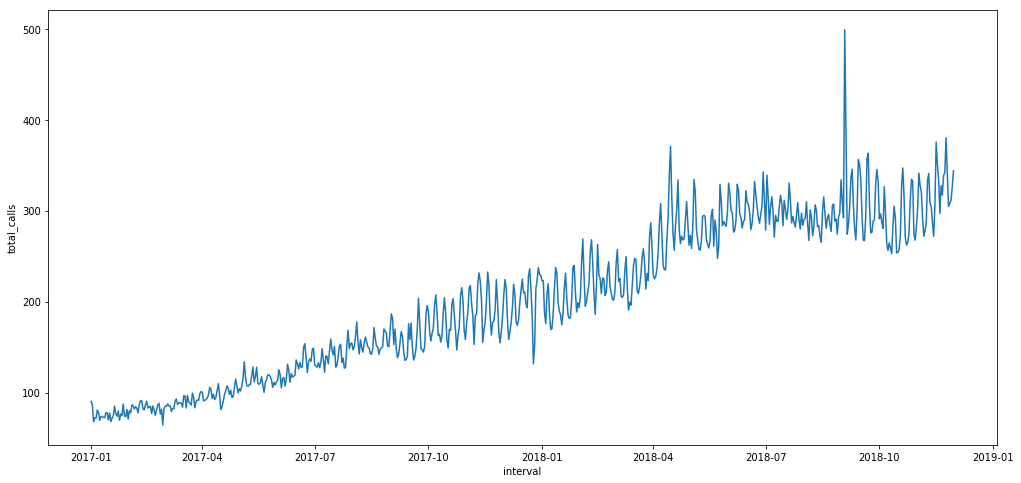

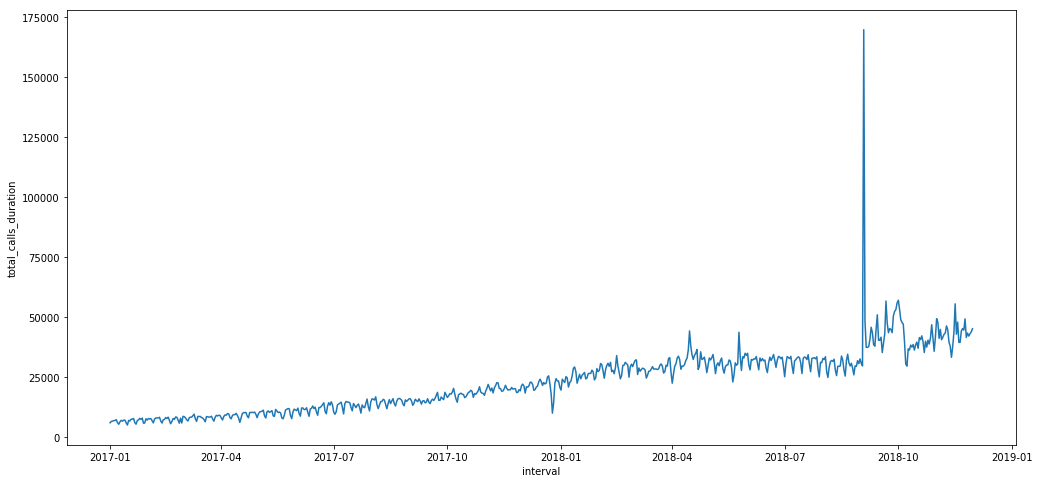

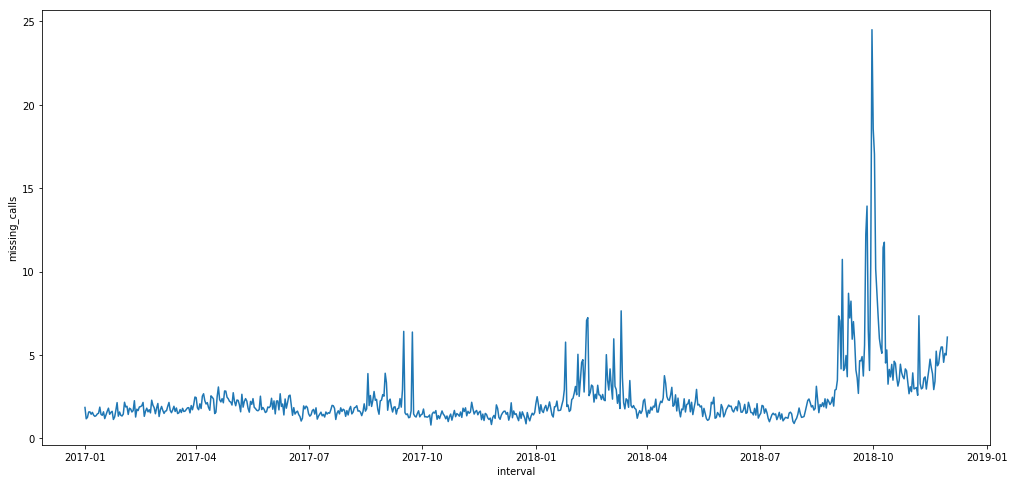

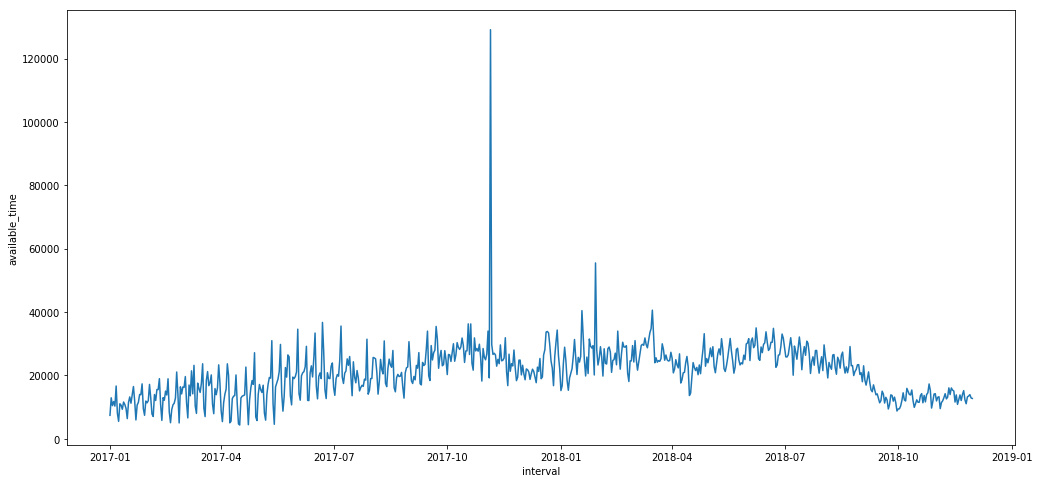

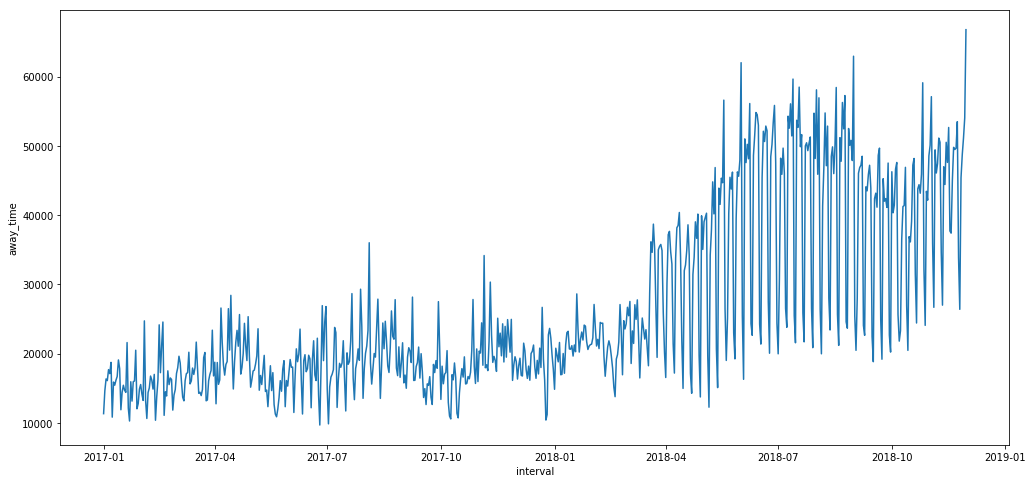

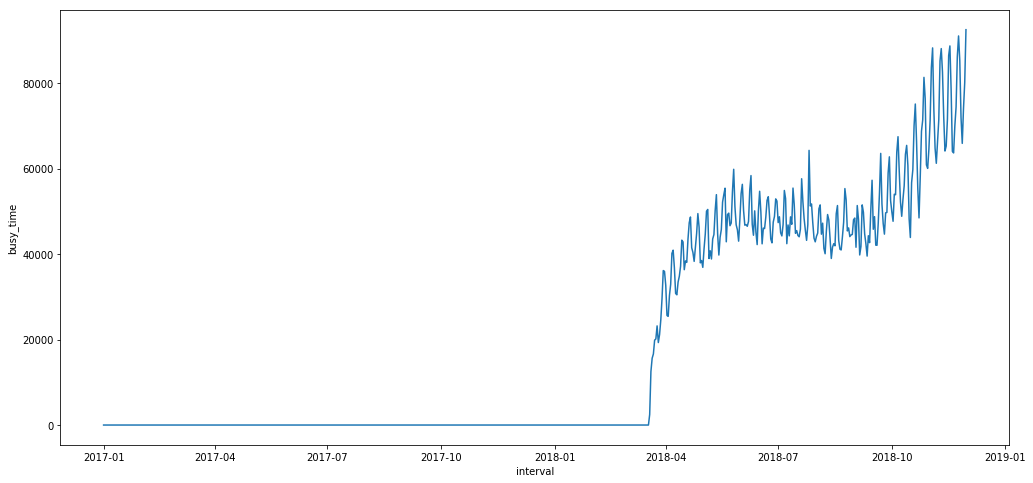

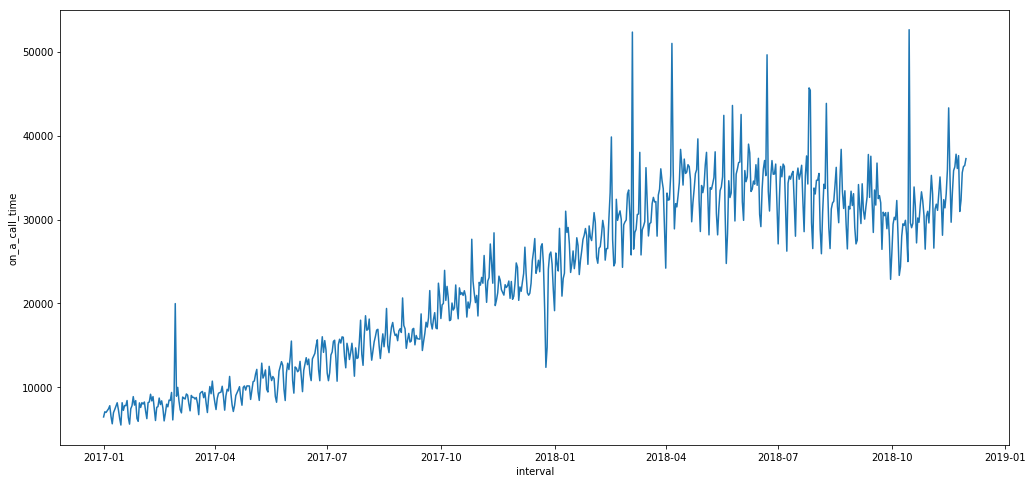

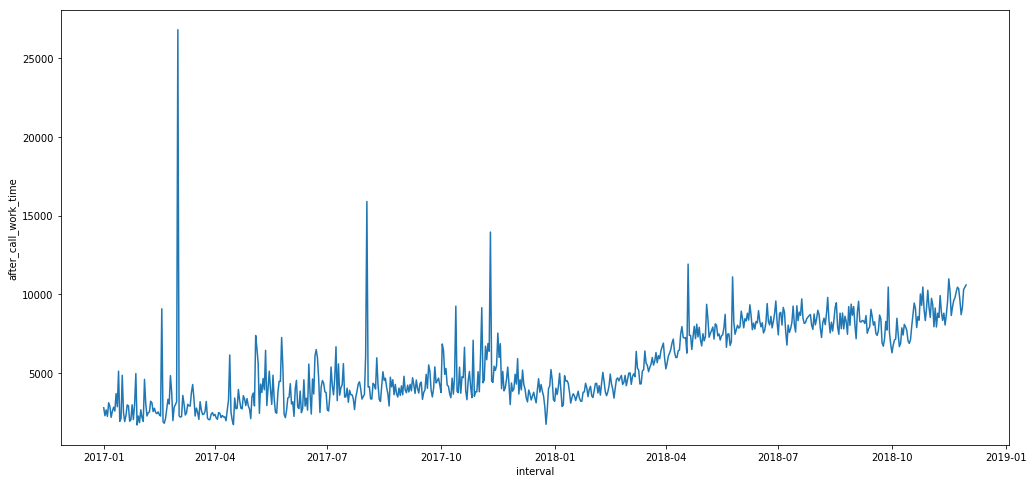

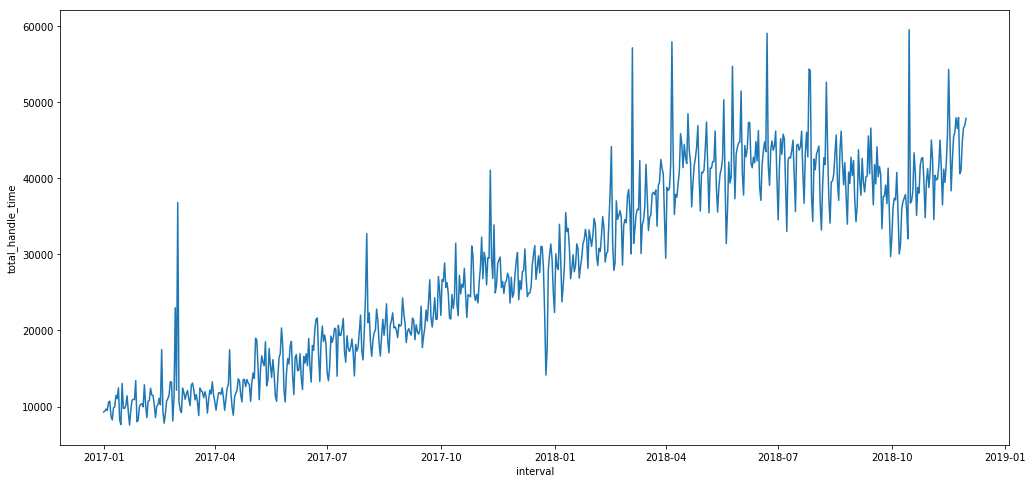

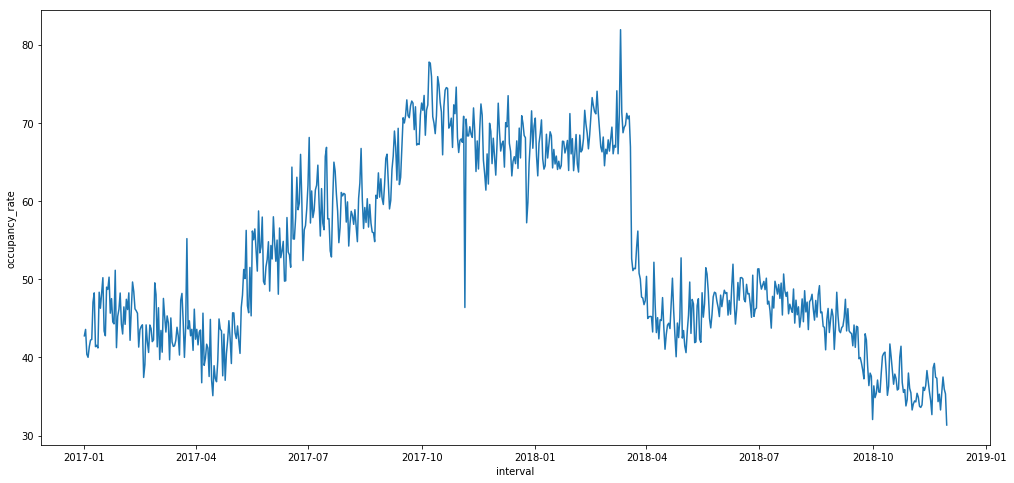

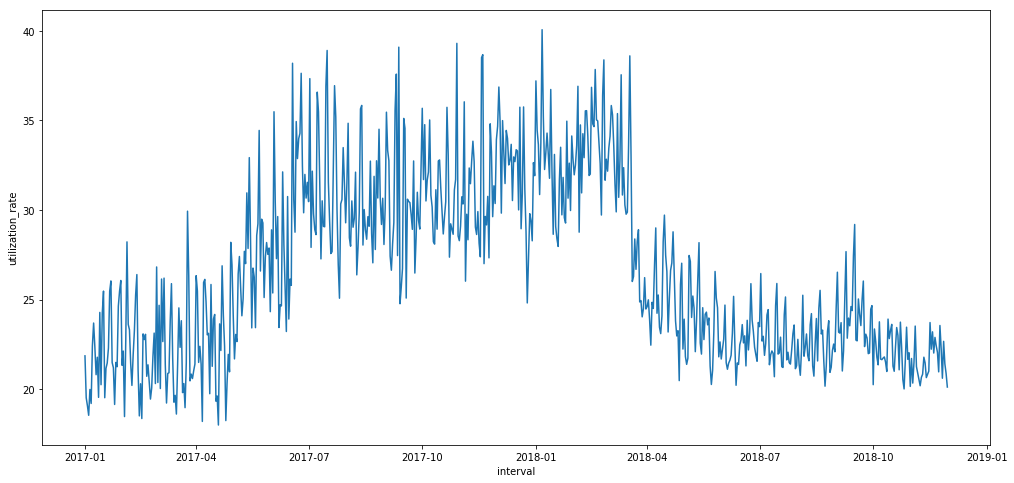

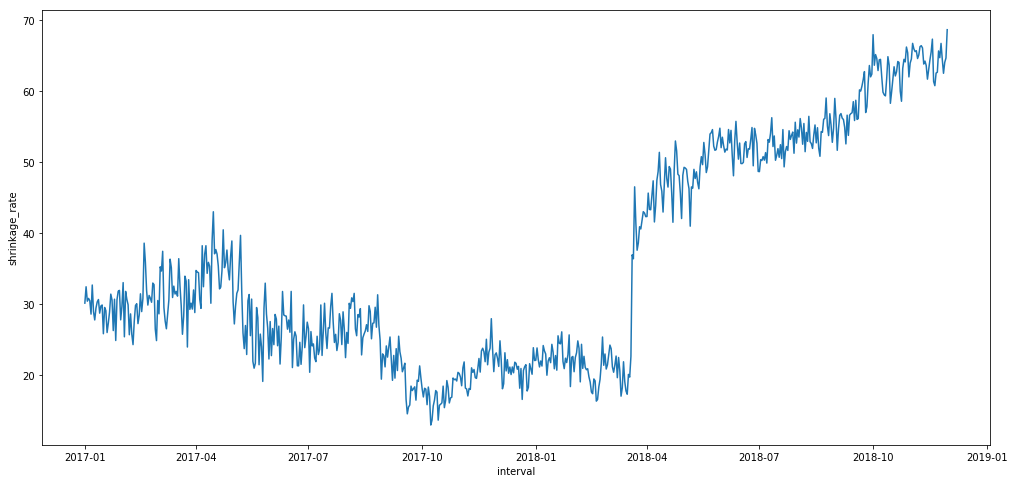

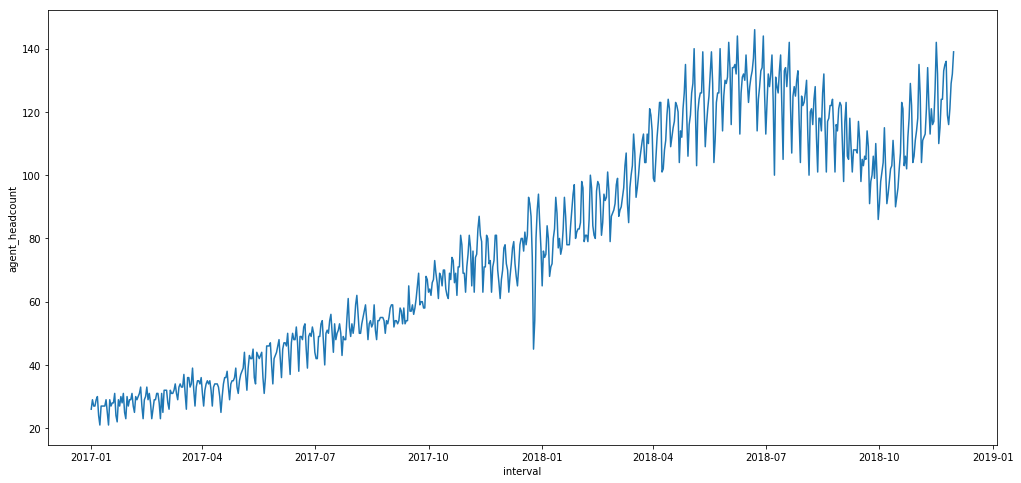

In [13]:
for col in daily.columns:
    plot_data(col, daily)

In [14]:
daily.isna().sum()

total_calls             0
total_calls_duration    0
missing_calls           0
available_time          0
away_time               0
busy_time               0
on_a_call_time          0
after_call_work_time    0
total_handle_time       0
occupancy_rate          0
utilization_rate        0
shrinkage_rate          0
agent_headcount         0
dtype: int64

In [ ]:
#import utils
#from fbprophet import Prophet
#import loggin 
#logging.getLoger().setLevel(logging.ERROR)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e01380c50>,
      dtype=object)

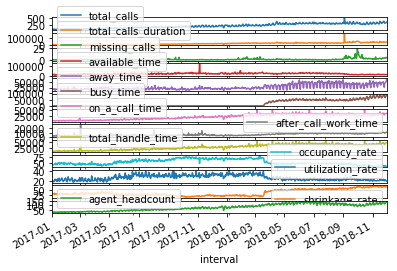

In [15]:
# Features vs Y
features_daily_considered = ['total_calls', 'total_calls_duration', 'missing_calls', 'available_time', 'away_time', 'busy_time', 'on_a_call_time', 'after_call_work_time', 'total_handle_time', 'occupancy_rate', 'utilization_rate', 'shrinkage_rate', 'agent_headcount']
features_daily = daily[features_daily_considered]
#features.index = daily['interval']
features_daily.head()
features_daily.plot(subplots=True)

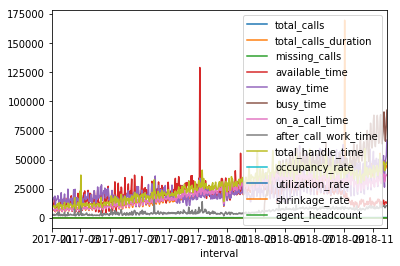

In [16]:
features_daily.plot(subplots=False)

In [17]:
!python -m pip install pystan

In [18]:
!python -m pip install fbprophet

In [19]:
!python -m pip install plotly

In [20]:
!python -m pip install utils

In [21]:
!python -m pip install logging

  Using cached https://files.pythonhosted.org/packages/93/4b/979db9e44be09f71e85c9c8cfc42f258adfb7d93ce01deed2788b2948919/logging-0.4.9.6.tar.gz
    Complete output from command python setup.py egg_info:
    running egg_info
    creating pip-egg-info/logging.egg-info
    writing pip-egg-info/logging.egg-info/PKG-INFO
    writing dependency_links to pip-egg-info/logging.egg-info/dependency_links.txt
    writing top-level names to pip-egg-info/logging.egg-info/top_level.txt
    writing manifest file 'pip-egg-info/logging.egg-info/SOURCES.txt'
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-h4okg969/logging/setup.py", line 13, in <module>
        packages = ["logging"],
      File "/home/local/FARFETCH/tiagosouza.oliveira/anaconda3/lib/python3.7/distutils/core.py", line 148, in setup
        dist.run_commands()
      File "/home/local/FARFETCH/tiagosouza.oliveira/anaconda3/lib/python3.7/distutils/dist.py", line 966, in run_com

In [23]:
!python -m pip install pandas_profiling

In [24]:
import utils
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)
import pandas_profiling

In [25]:
daily.profile_report()

### PCA

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [37]:
daily.head()

total_calls  total_calls_duration  missing_calls  available_time  \
interval                                                                       
2017-01-01    90.333333           5967.968750       1.854167     7392.666667   
2017-01-02    86.708333           6546.312500       1.177083    12930.072917   
2017-01-03    67.989583           6639.166667       1.260417    10449.593750   
2017-01-04    72.281250           6911.500000       1.583333    11757.072917   
2017-01-05    71.916667           6902.552083       1.593750    10296.281250   

               away_time  busy_time  on_a_call_time  after_call_work_time  \
interval                                                                    
2017-01-01  11345.916667        0.0     6484.937500           2794.697917   
2017-01-02  14646.833333        0.0     7098.916667           2291.583333   
2017-01-03  16357.708333        0.0     7023.895833           2658.697917   
2017-01-04  16117.427083        0.0     7233.937500           2251.687500   
2017-01-05  17701.645833        0.0     7456.333333           3114.458333   

            total_handle_time  occupancy_rate  utilization_rate  \
interval                                                          
2017-01-01        9279.635417       42.765830         21.863427   
2017-01-02        9390.500000       43.586291         19.526052   
2017-01-03        9682.593750       40.408136         19.074831   
2017-01-04        9485.625000       40.017575         18.547474   
2017-01-05       10570.791667       41.373515         19.988262   

            shrinkage_rate  agent_headcount  
interval                                     
2017-01-01       30.150837        26.260417  
2017-01-02       32.455375        29.927083  
2017-01-03       30.425197        27.281250  
2017-01-04       30.815758        27.906250  
2017-01-05       30.501485        29.395833

In [38]:
daily.shape

(699, 13)

In [40]:
daily.head()

total_calls  total_calls_duration  missing_calls  available_time  \
interval                                                                       
2017-01-01    90.333333           5967.968750       1.854167     7392.666667   
2017-01-02    86.708333           6546.312500       1.177083    12930.072917   
2017-01-03    67.989583           6639.166667       1.260417    10449.593750   
2017-01-04    72.281250           6911.500000       1.583333    11757.072917   
2017-01-05    71.916667           6902.552083       1.593750    10296.281250   

               away_time  busy_time  on_a_call_time  after_call_work_time  \
interval                                                                    
2017-01-01  11345.916667        0.0     6484.937500           2794.697917   
2017-01-02  14646.833333        0.0     7098.916667           2291.583333   
2017-01-03  16357.708333        0.0     7023.895833           2658.697917   
2017-01-04  16117.427083        0.0     7233.937500           2251.687500   
2017-01-05  17701.645833        0.0     7456.333333           3114.458333   

            total_handle_time  occupancy_rate  utilization_rate  \
interval                                                          
2017-01-01        9279.635417       42.765830         21.863427   
2017-01-02        9390.500000       43.586291         19.526052   
2017-01-03        9682.593750       40.408136         19.074831   
2017-01-04        9485.625000       40.017575         18.547474   
2017-01-05       10570.791667       41.373515         19.988262   

            shrinkage_rate  agent_headcount  
interval                                     
2017-01-01       30.150837               26  
2017-01-02       32.455375               29  
2017-01-03       30.425197               27  
2017-01-04       30.815758               27  
2017-01-05       30.501485               29

In [27]:
#Split X & label
X = daily.drop('agent_headcount', axis=1)
y = daily['agent_headcount']

In [42]:
y.head()

interval
2017-01-01    26
2017-01-02    29
2017-01-03    27
2017-01-04    27
2017-01-05    29
Name: agent_headcount, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123)

In [29]:
#scaling our variable:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
pca = PCA(n_components=4) #reducing dimensionality
principalComponents = pca.fit_transform(X_train_scaled)

In [31]:
clf = SVC(gamma='auto')
clf.fit(principalComponents, y_train)  
clf.score(principalComponents, y_train)

0.2331288343558282

In [32]:
#pca.explained_variance_ratio_
n_pca = pca.components_.shape[0]
# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pca)]

most_important_names = [features_daily_considered[most_important[i]] for i in range(n_pca)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pca)}

# build the dataframe
df = pd.DataFrame(dic.items())
df
#https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/#targetText=Applying%20PCA&targetText=Therefore%2C%20PCA%20can%20be%20considered,feature%20set%20to%20these%20methods.
#https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

0               1
0  PC0       busy_time
1  PC1  occupancy_rate
2  PC2   missing_calls
3  PC3  available_time

In [33]:
X_train_scaled[5]

array([-1.14215205, -1.01857136, -0.10014422, -1.90356697, -0.52253445,
       -0.72588646, -1.23426753, -1.0576891 , -1.26145886, -0.89908798,
        0.31019178,  0.05415692])

In [34]:
%%timeit
score_scaled = cross_val_score(clf, X_train_scaled, y_train, cv=5)
np.mean(score_scaled)

282 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#import numpy as np
#from sklearn import linear_model
#from sklearn import svm

#classifiers = [
#    svm.SVR(),
#    linear_model.SGDRegressor(),
#    linear_model.BayesianRidge(),
#    linear_model.LassoLars(),
#    linear_model.ARDRegression(),
#    linear_model.PassiveAggressiveRegressor(),
#    linear_model.TheilSenRegressor(),
#    linear_model.LinearRegression()]

#trainingData    = np.array([ [2.3, 4.3, 2.5],  [1.3, 5.2, 5.2],  [3.3, 2.9, 0.8],  [3.1, 4.3, 4.0]  ])
#trainingScores  = np.array( [3.4, 7.5, 4.5, 1.6] )
#predictionData  = np.array([ [2.5, 2.4, 2.7],  [2.7, 3.2, 1.2] ])

#for item in classifiers:
#    print(item)
#    clf = item
#    clf.fit(trainingData, trainingScores)
#    print(clf.predict(predictionData),'\n')


In [ ]:
#RAPID cuDF
#https://pypi.org/project/cudf/
#https://github.com/nuclio/rapids/blob/master/demo/benchmark_cudf_vs_pd.ipynb
# CUDA 9.2
#pip install cudf-cuda92

# CUDA 10.0.
#pip install cudf-cuda100
#import cudf


## Start with Prophet

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4df55fe278>],
      dtype=object)

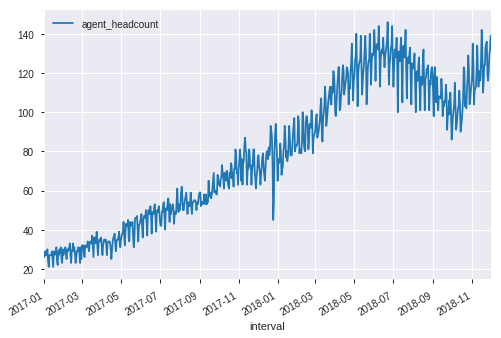

In [35]:
#Features vs Labels
features_drop = ['total_calls', 'total_calls_duration', 'missing_calls', 'available_time', 'away_time', 'busy_time', 'on_a_call_time', 'after_call_work_time', 'total_handle_time', 'occupancy_rate', 'utilization_rate', 'shrinkage_rate']
daily_xy = daily.drop(features_drop, axis=1).copy()
daily_xy.head()
daily_xy.plot(subplots=True)

In [36]:
#Shaping data for Prophet
df = daily_xy.reset_index()
df.columns = ['ds','y']
df.head()

ds   y
0  2017-01-01  26
1  2017-01-02  29
2  2017-01-03  27
3  2017-01-04  27
4  2017-01-05  29

In [37]:
#Predict next 30 days
pred_size = 30
train_df = df[:-pred_size]

In [44]:
df.tail()

ds           y
694  2018-11-26  116.489583
695  2018-11-27  121.760417
696  2018-11-28  129.020833
697  2018-11-29  132.489583
698  2018-11-30  139.552083

## Without seasonality

In [38]:
m_WOseason = Prophet()
m_WOseason.fit(train_df)
future_WOseason = m_WOseason.make_future_dataframe(periods=pred_size)
forecast_WOseason = m_WOseason.predict(future_WOseason) 
forecast_WOseason.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-01-01  24.844816    9.860798   23.977224    24.844816    24.844816   
1 2017-01-02  24.939222   15.748606   29.344965    24.939222    24.939222   
2 2017-01-03  25.033628   16.600096   30.405105    25.033628    25.033628   
3 2017-01-04  25.128035   18.776181   32.374856    25.128035    25.128035   
4 2017-01-05  25.222441   20.335615   34.521653    25.222441    25.222441   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -8.004963             -8.004963             -8.004963 -8.004963   
1       -2.383055             -2.383055             -2.383055 -2.383055   
2       -1.644398             -1.644398             -1.644398 -1.644398   
3        0.390234              0.390234              0.390234  0.390234   
4        2.440536              2.440536              2.440536  2.440536   

   weekly_lower  weekly_upper  multiplicative_terms  \
0     -8.004963     -8.004963                   0.0   
1     -2.383055     -2.383055                   0.0   
2     -1.644398     -1.644398                   0.0   
3      0.390234      0.390234                   0.0   
4      2.440536      2.440536                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0  16.839853  
1                         0.0                         0.0  22.556167  
2                         0.0                         0.0  23.389230  
3                         0.0                         0.0  25.518269  
4                         0.0                         0.0  27.662978

In [39]:
forecast_WOseason.shape, train_df.shape

((699, 16), (669, 2))

In [ ]:
# yhat represents the prediction, while yhat_lower and yhat_upper represent the lower and upper bound of the prediction respectively.

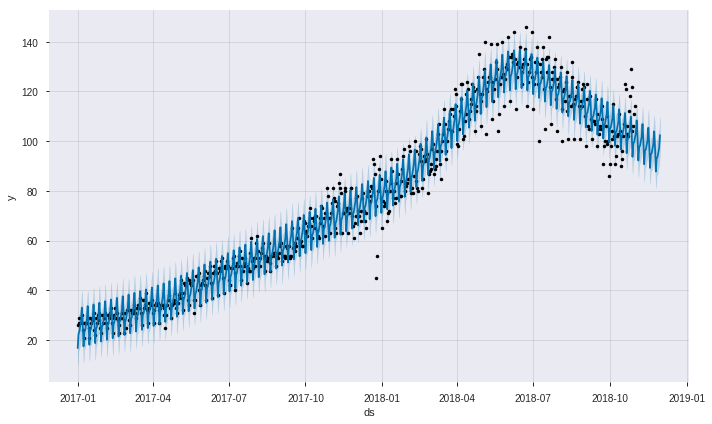

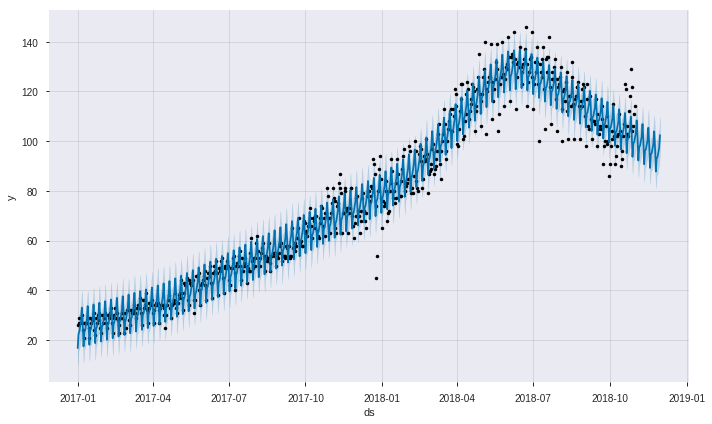

In [40]:
m_WOseason.plot(forecast_WOseason)

In [41]:
forecast_WOseason.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
694 2018-11-26  95.573351   86.398610  100.562968    94.935727    96.287306   
695 2018-11-27  95.361474   86.637056  100.799546    94.680554    96.164016   
696 2018-11-28  95.149597   89.011501  103.064295    94.424379    95.991805   
697 2018-11-29  94.937720   90.252751  104.317414    94.149114    95.843694   
698 2018-11-30  94.725843   95.829446  109.797253    93.876023    95.692184   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
694       -2.383055             -2.383055             -2.383055 -2.383055   
695       -1.644398             -1.644398             -1.644398 -1.644398   
696        0.390234              0.390234              0.390234  0.390234   
697        2.440536              2.440536              2.440536  2.440536   
698        7.726348              7.726348              7.726348  7.726348   

     weekly_lower  weekly_upper  multiplicative_terms  \
694     -2.383055     -2.383055                   0.0   
695     -1.644398     -1.644398                   0.0   
696      0.390234      0.390234                   0.0   
697      2.440536      2.440536                   0.0   
698      7.726348      7.726348                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
694                         0.0                         0.0   93.190296  
695                         0.0                         0.0   93.717076  
696                         0.0                         0.0   95.539831  
697                         0.0                         0.0   97.378256  
698                         0.0                         0.0  102.452191

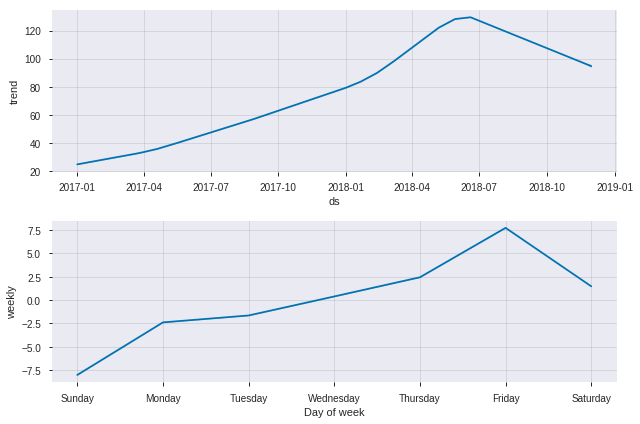

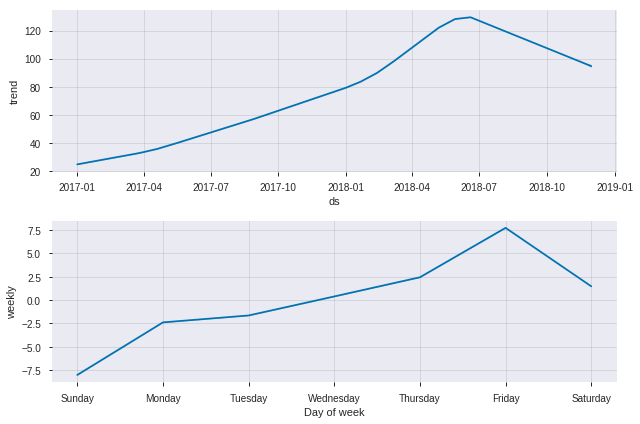

In [42]:
m_WOseason.plot_components(forecast_WOseason)

## With Seasonality

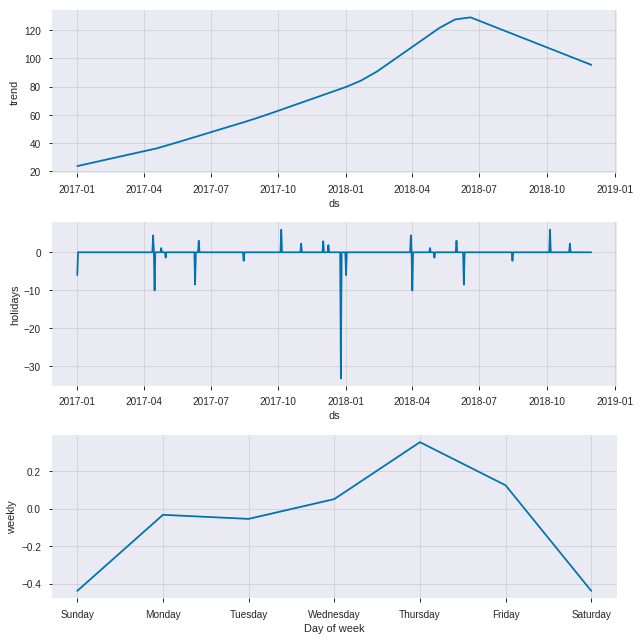

In [55]:
m_WSeason = Prophet(weekly_seasonality=False)
#m_WSeason.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m_WSeason.add_seasonality(name='weekly', period=6, fourier_order=3, prior_scale=0.1)
m_WSeason.add_country_holidays(country_name='PT')
m_WSeason.fit(train_df)
future_Wseason = m_WSeason.make_future_dataframe(periods=pred_size)
forecast_WSeason = m_WSeason.predict(future_Wseason)


fig_s = m_WSeason.plot_components(forecast_WSeason)




#m_WOseason = Prophet()
#m_WOseason.fit(train_df)
#future_WOseason = m_WOseason.make_future_dataframe(periods=pred_size)
#forecast_WOseason = m_WOseason.predict(future_WOseason) 
#forecast_WOseason.head()
#https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

In [48]:
m_WSeason.train_holiday_names


0                         Ano Novo
1                Sexta-feira Santa
2                           Páscoa
3                    Corpo de Deus
4         Implantação da República
5           Dia de Todos os Santos
6     Restauração da Independência
7                 Dia da Liberdade
8               Dia do Trabalhador
9                  Dia de Portugal
10       Assunção de Nossa Senhora
11             Imaculada Conceição
12                   Christmas Day
dtype: object

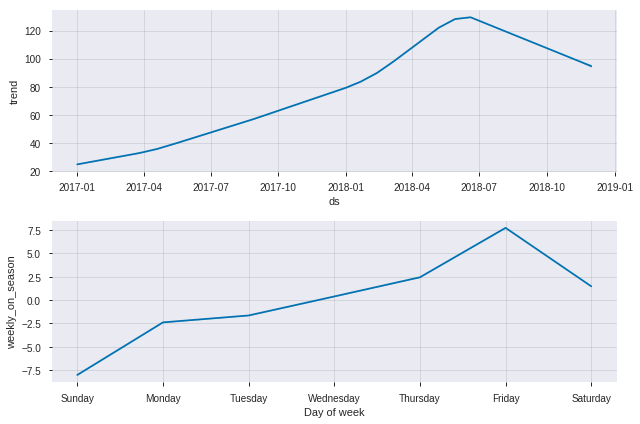

In [51]:
m_WSeasonCustom = Prophet(weekly_seasonality=False)
m_WSeasonCustom.add_seasonality(name='weekly_on_season', period=7, fourier_order=3)

m_WSeasonCustom.fit(train_df)
future_WSeasonCustom = m_WSeasonCustom.make_future_dataframe(periods=pred_size)
forecast_WSeasonCustom = m_WSeasonCustom.predict(future_WSeasonCustom)
fig = m_WSeasonCustom.plot_components(forecast_WSeasonCustom)


## Prophet Forecasting Comparison between mode with/without seasonality

In [56]:
def make_comparison(hist, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(hist.set_index('ds'))

In [63]:
def calculate_forecast_err(df, pred_size):
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    pred_part = df[-pred_size:]
    
    err_mean = lambda err_name: np.mean(np.abs(pred_part[err_name]))
    
    return {'MAPE': err_mean('p'), 'MAE': err_mean('e')}


In [61]:
#With Season
with_season = make_comparison(df, forecast_WSeason)


In [70]:
#Without Season
without_season = make_comparison(df, forecast_WOseason)


In [71]:
forecast_WOseason.shape

(699, 16)

In [72]:
forecast_WSeason.shape

(729, 16)

In [64]:
#With seasonality
for err_name, err_value in calculate_forecast_err(with_season, pred_size).items():
    print(err_name, err_value)
    

#mean absolute percentage error (MAPE)
#mean absolute error (MAE):
#https://towardsdatascience.com/time-series-forecasting-with-prophet-54f2ac5e722e

#https://research.fb.com/prophet-forecasting-at-scale/
#Where Prophet shines
#Not all forecasting problems can be solved by the same procedure. Prophet is optimized for the business forecast tasks we have encountered at Facebook, which typically have any of the following characteristics:

#hourly, daily, or weekly observations with at least a few months (preferably a year) of history
#strong multiple “human-scale” seasonalities: day of week and time of year
#important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
#a reasonable number of missing observations or large outliers
#historical trend changes, for instance due to product launches or logging changes
#trends that are non-linear growth curves, where a trend hits a natural limit or saturates

MAPE 19.555130194741835
MAE 24.750557189725885


In [71]:
#Without seasonality
for err_name, err_value in calculate_forecast_err(without_season, pred_size).items():
    print(err_name, err_value)
    

#mean absolute percentage error (MAPE)
#mean absolute error (MAE):
#https://towardsdatascience.com/time-series-forecasting-with-prophet-54f2ac5e722e

#https://research.fb.com/prophet-forecasting-at-scale/
#Where Prophet shines
#Not all forecasting problems can be solved by the same procedure. Prophet is optimized for the business forecast tasks we have encountered at Facebook, which typically have any of the following characteristics:

#hourly, daily, or weekly observations with at least a few months (preferably a year) of history
#strong multiple “human-scale” seasonalities: day of week and time of year
#important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
#a reasonable number of missing observations or large outliers
#historical trend changes, for instance due to product launches or logging changes
#trends that are non-linear growth curves, where a trend hits a natural limit or saturates

MAPE 20.049224122462167
MAE 25.06304567381619


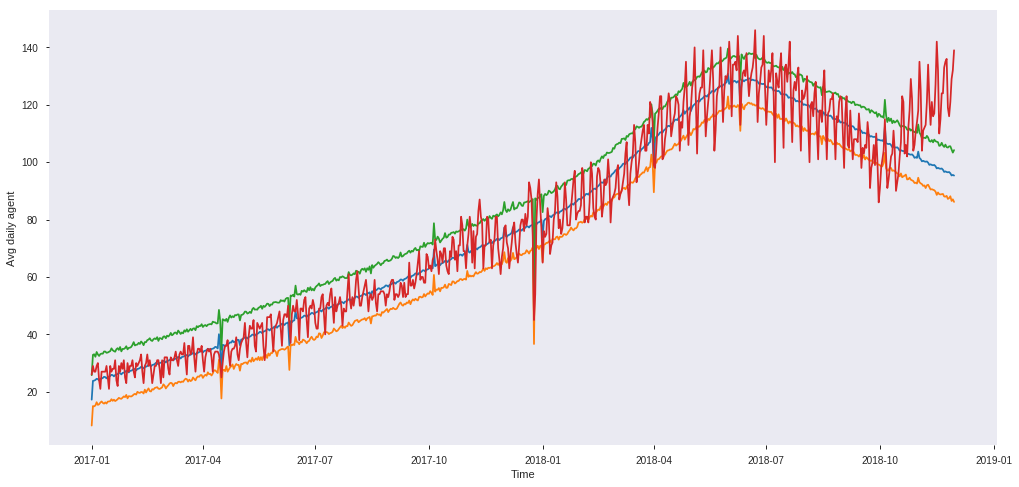

In [67]:
plt.figure(figsize=(17,8))
plt.plot(with_season['yhat'])
plt.plot(with_season['yhat_lower'])
plt.plot(with_season['yhat_upper'])
plt.plot(with_season['y'])
plt.xlabel('Time')
plt.ylabel('Avg daily agent')
plt.grid(False)
plt.show()

#https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

In [68]:
with_season.head()

yhat  yhat_lower  yhat_upper   y
ds                                               
2017-01-01  17.256058    8.234879   25.788642  26
2017-01-02  23.795360   15.015849   32.857796  29
2017-01-03  23.889304   14.929868   33.071487  27
2017-01-04  24.110171   15.231996   32.197478  27
2017-01-05  24.528743   16.365319   33.862328  29

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4df5970c18>,
      dtype=object)

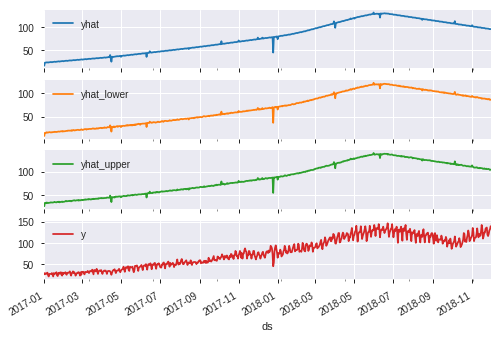

In [69]:
features_cons = ['yhat', 'yhat_lower', 'yhat_upper', 'y']
features_final = with_season[features_cons]
features_final.index = df['ds']
features_final.plot(subplots=True)
#https://research.fb.com/prophet-forecasting-at-scale/
#features_final.head()


In [72]:
with_season.index.name

'ds'

## Forecasting with time steps in Hour interval using Facebook Prophet

In [73]:
data_hour['time'] = pd.to_datetime(data_hour['interval']).dt.time
data_hour['interval'] = pd.to_datetime(data_hour['interval'])
data_hour['interval'] = data_hour['interval'].apply(lambda x: pd.to_datetime(x, format='%Y%m%d', errors='ignore').date())
data_hour.shape

(67104, 15)

In [29]:
data_hour.head()

interval  total_calls  total_calls_duration  missing_calls  \
0  2017-01-01          227                 11880              8   
1  2017-01-01          235                 15297              4   
2  2017-01-01          219                 13739              5   
3  2017-01-01          256                 16534              5   
4  2017-01-01          240                 17692             14   

   available_time  away_time  busy_time  on_a_call_time  after_call_work_time  \
0            9721      28806          0           14047                  4543   
1           10716      34697          0           16636                  4932   
2           16380      24186          0           16092                  6280   
3            8086      12307          0           16253                  5932   
4            8371      25296          0           18225                  7217   

   total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
0              18590       49.566679         32.547228       50.433321   
1              21568       48.198743         32.200176       51.801257   
2              22372       61.571705         35.546093       38.428295   
3              22185       71.095401         52.104373       28.904599   
4              25442       57.204487         43.042515       42.795513   

   agent_headcount      time  
0               56  00:00:00  
1               60  00:15:00  
2               61  00:30:00  
3               57  00:45:00  
4               61  01:00:00

In [ ]:
#hourly = data_hour.groupby(['interval', 'time']).mean()

In [74]:
data_hour['time'] = data_hour['time'].apply(lambda x: x.hour)

In [31]:
data_hour.shape

(67104, 15)

In [75]:
#transform time in continuous number & groupby
hourly = data_hour.groupby(['interval','time']).mean()

In [33]:
hourly.shape

(16776, 13)

In [34]:
hourly.head(48)

total_calls  total_calls_duration  missing_calls  \
interval   time                                                     
2017-01-01 0          234.25              14362.50           5.50   
           1          221.50              15847.50           7.50   
           2          182.25              14077.25           4.25   
           3          112.00               7649.75           1.00   
           4           72.50               6188.50           2.25   
           5           29.50               2049.00           4.25   
           6            9.00                397.00           2.25   
           7            1.25                 17.75           1.00   
           8            0.75                 11.25           0.25   
           9            0.25                  0.50           0.00   
           10           0.00                  0.00           0.00   
           11           0.00                  0.00           0.00   
           12           0.00                  0.00           0.00   
           13           0.50                 17.25           0.25   
           14           3.00                221.25           0.25   
           15          32.00               2058.25           1.00   
           16          60.75               3663.00           0.75   
           17         103.50               5673.25           1.50   
           18         156.00               8900.50           1.25   
           19         175.50              10881.25           2.50   
           20         164.00              11261.75           2.75   
           21         198.00              12967.75           3.75   
           22         205.75              13633.75           1.25   
           23         205.75              13352.25           1.00   
2017-01-02 0          208.25              14671.25           3.00   
           1          192.25              12948.00           2.50   
           2          165.75              13305.00           1.75   
           3           95.50               7574.25           1.00   
           4           50.00               3643.50           0.50   
           5           25.25               1303.25           0.25   
           6           11.00                252.25           1.25   
           7            2.00                 81.25           0.25   
           8            0.00                  0.00           0.00   
           9            0.25                  5.75           0.25   
           10           0.25                 13.25           0.25   
           11           0.25                  6.50           0.25   
           12           0.25                 14.75           0.00   
           13           2.25                 83.00           0.50   
           14          10.75               1003.50           0.25   
           15          48.50               3163.00           0.75   
           16         102.25               6381.50           0.50   
           17         137.00               9779.00           1.50   
           18         150.50              11281.75           2.50   
           19         165.00              12137.75           2.75   
           20         169.50              16995.50           2.25   
           21         185.50              15216.25           2.50   
           22         176.25              14501.50           1.75   
           23         182.50              12749.75           1.75   

                 available_time  away_time  busy_time  on_a_call_time  \
interval   time                                                         
2017-01-01 0           11225.75   24999.00        0.0        15757.00   
           1            7871.50   24801.25        0.0        16244.75   
           2            7115.50   27580.25        0.0        13618.25   
           3            5930.25   21274.00        0.0         8543.50   
           4            5619.25   14557.00        0.0         5081.50   
           5             767.25    5763.75        0.0  

In [76]:
#pd.to_datetime(hourly['interval'] + ' ' + hourly['time'])

hourly_ds = hourly.reset_index()

#hourly_ds = daily_xy.reset_index()
#hourly_ds.columns = ['ds','y']
#hourly_ds.head()

#hourly['hour'] = hourly['time'].apply(lambda x: "{0}:00:00".format(x))

In [36]:
hourly_ds.head()

interval  time  total_calls  total_calls_duration  missing_calls  \
0  2017-01-01     0       234.25              14362.50           5.50   
1  2017-01-01     1       221.50              15847.50           7.50   
2  2017-01-01     2       182.25              14077.25           4.25   
3  2017-01-01     3       112.00               7649.75           1.00   
4  2017-01-01     4        72.50               6188.50           2.25   

   available_time  away_time  busy_time  on_a_call_time  after_call_work_time  \
0        11225.75   24999.00        0.0        15757.00               5421.75   
1         7871.50   24801.25        0.0        16244.75               6733.75   
2         7115.50   27580.25        0.0        13618.25               7381.25   
3         5930.25   21274.00        0.0         8543.50               3581.00   
4         5619.25   14557.00        0.0         5081.50               1402.25   

   total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
0           21178.75       57.608132         38.099467       42.391868   
1           22978.50       55.411580         41.251054       44.588420   
2           20999.50       51.097231         38.237233       48.902769   
3           12124.50       48.516581         32.539646       51.483419   
4            6483.75       46.106626         23.865390       53.893374   

   agent_headcount  
0             58.5  
1             57.0  
2             47.5  
3             34.0  
4             24.0

In [77]:
hourly_ds['time'] = hourly_ds['time'].apply(lambda x: "{0}:00:00".format(x))

In [78]:
hourly_ds['time'].head()

0    0:00:00
1    1:00:00
2    2:00:00
3    3:00:00
4    4:00:00
Name: time, dtype: object

In [79]:
#hourly_ds['time'].time()
#hourly_ds['time'].apply(lambda x: x.time())
hourly_ds['time'] = hourly_ds['time'].apply(lambda x: pd.datetime.strptime(x, '%H:%M:%S').time())

#pd.to_datetime(hourly_ds['interval'] + ' ' + hourly_ds['time'].time())

In [80]:
hourly_ds['time'].head()

0    00:00:00
1    01:00:00
2    02:00:00
3    03:00:00
4    04:00:00
Name: time, dtype: object

In [81]:
#pd.to_datetime(hourly_ds['interval'] + ' ' + hourly_ds['time'])
hourly_ds['date_time'] = hourly_ds[['interval','time']].apply(lambda x: pd.datetime.combine(*list(x)),axis=1)


In [42]:
hourly_ds.head()


interval      time  total_calls  total_calls_duration  missing_calls  \
0  2017-01-01  00:00:00       234.25              14362.50           5.50   
1  2017-01-01  01:00:00       221.50              15847.50           7.50   
2  2017-01-01  02:00:00       182.25              14077.25           4.25   
3  2017-01-01  03:00:00       112.00               7649.75           1.00   
4  2017-01-01  04:00:00        72.50               6188.50           2.25   

   available_time  away_time  busy_time  on_a_call_time  after_call_work_time  \
0        11225.75   24999.00        0.0        15757.00               5421.75   
1         7871.50   24801.25        0.0        16244.75               6733.75   
2         7115.50   27580.25        0.0        13618.25               7381.25   
3         5930.25   21274.00        0.0         8543.50               3581.00   
4         5619.25   14557.00        0.0         5081.50               1402.25   

   total_handle_time  occupancy_rate  utilization_rate  shrinkage_rate  \
0           21178.75       57.608132         38.099467       42.391868   
1           22978.50       55.411580         41.251054       44.588420   
2           20999.50       51.097231         38.237233       48.902769   
3           12124.50       48.516581         32.539646       51.483419   
4            6483.75       46.106626         23.865390       53.893374   

   agent_headcount           date_time  
0             58.5 2017-01-01 00:00:00  
1             57.0 2017-01-01 01:00:00  
2             47.5 2017-01-01 02:00:00  
3             34.0 2017-01-01 03:00:00  
4             24.0 2017-01-01 04:00:00

In [82]:
hourly_ds_final = hourly_ds.drop(['interval'], axis=1)

In [83]:
hourly_ds_final = hourly_ds.drop(['time'], axis=1)

In [84]:
hourly_ds_final = hourly_ds_final.reset_index()

In [85]:
hourly_ds_final=hourly_ds_final.drop(['interval'], axis=1)

In [86]:
hourly_ds_final=hourly_ds_final.drop(['index'], axis=1)

In [87]:
hourly_ds_final.index=hourly_ds['date_time']

In [88]:
hourly_ds_final.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2018-11-30 14:00:00', '2018-11-30 15:00:00',
               '2018-11-30 16:00:00', '2018-11-30 17:00:00',
               '2018-11-30 18:00:00', '2018-11-30 19:00:00',
               '2018-11-30 20:00:00', '2018-11-30 21:00:00',
               '2018-11-30 22:00:00', '2018-11-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=16776, freq=None)

In [89]:
hourly_ds_final.head()

total_calls  total_calls_duration  missing_calls  \
date_time                                                               
2017-01-01 00:00:00       234.25              14362.50           5.50   
2017-01-01 01:00:00       221.50              15847.50           7.50   
2017-01-01 02:00:00       182.25              14077.25           4.25   
2017-01-01 03:00:00       112.00               7649.75           1.00   
2017-01-01 04:00:00        72.50               6188.50           2.25   

                     available_time  away_time  busy_time  on_a_call_time  \
date_time                                                                   
2017-01-01 00:00:00        11225.75   24999.00        0.0        15757.00   
2017-01-01 01:00:00         7871.50   24801.25        0.0        16244.75   
2017-01-01 02:00:00         7115.50   27580.25        0.0        13618.25   
2017-01-01 03:00:00         5930.25   21274.00        0.0         8543.50   
2017-01-01 04:00:00         5619.25   14557.00        0.0         5081.50   

                     after_call_work_time  total_handle_time  occupancy_rate  \
date_time                                                                      
2017-01-01 00:00:00               5421.75           21178.75       57.608132   
2017-01-01 01:00:00               6733.75           22978.50       55.411580   
2017-01-01 02:00:00               7381.25           20999.50       51.097231   
2017-01-01 03:00:00               3581.00           12124.50       48.516581   
2017-01-01 04:00:00               1402.25            6483.75       46.106626   

                     utilization_rate  shrinkage_rate  agent_headcount  \
date_time                                                                
2017-01-01 00:00:00         38.099467       42.391868             58.5   
2017-01-01 01:00:00         41.251054       44.588420             57.0   
2017-01-01 02:00:00         38.237233       48.902769             47.5   
2017-01-01 03:00:00         32.539646       51.483419             34.0   
2017-01-01 04:00:00         23.865390       53.893374             24.0   

                              date_time  
date_time                                
2017-01-01 00:00:00 2017-01-01 00:00:00  
2017-01-01 01:00:00 2017-01-01 01:00:00  
2017-01-01 02:00:00 2017-01-01 02:00:00  
2017-01-01 03:00:00 2017-01-01 03:00:00  
2017-01-01 04:00:00 2017-01-01 04:00:00

In [90]:
#Casting agent_headcount from flot to Int. Avoid error continuous in the prediction
hourly_ds_final['agent_headcount'] = hourly_ds_final['agent_headcount'].astype('int64', copy=False)

In [91]:
#Casting total_calls from flot to Int. Avoid error continuous in the prediction
hourly_ds_final['total_calls'] = hourly_ds_final['total_calls'].astype('int64', copy=False)

In [92]:
#Casting missing_calls from flot to Int. Avoid error continuous in the prediction
hourly_ds_final['missing_calls'] = hourly_ds_final['missing_calls'].astype('int64', copy=False)

In [93]:
hourly_ds_final.tail()

total_calls  total_calls_duration  missing_calls  \
date_time                                                               
2018-11-30 19:00:00          584              88801.25             10   
2018-11-30 20:00:00          541              83717.00              7   
2018-11-30 21:00:00          602              86203.00              8   
2018-11-30 22:00:00          625              88678.50              6   
2018-11-30 23:00:00          740             111172.75             13   

                     available_time  away_time  busy_time  on_a_call_time  \
date_time                                                                   
2018-11-30 19:00:00        15527.25   109720.0  133725.75        71003.75   
2018-11-30 20:00:00        20755.50   169298.0  136899.25        67389.25   
2018-11-30 21:00:00        17311.50   177565.0  232278.00        76733.75   
2018-11-30 22:00:00        16777.00   206486.5  159455.50        76648.00   
2018-11-30 23:00:00        17289.75    97653.5  227306.75        80723.50   

                     after_call_work_time  total_handle_time  occupancy_rate  \
date_time                                                                      
2018-11-30 19:00:00              17413.75           88417.50       30.139939   
2018-11-30 20:00:00              18705.25           86094.50       27.536738   
2018-11-30 21:00:00              19498.00           96231.75       22.621578   
2018-11-30 22:00:00              19476.75           96124.75       24.965508   
2018-11-30 23:00:00              27121.00          107844.50       27.960976   

                     utilization_rate  shrinkage_rate  agent_headcount  \
date_time                                                                
2018-11-30 19:00:00         25.649366       69.860061              233   
2018-11-30 20:00:00         22.327189       72.463262              242   
2018-11-30 21:00:00         19.126319       77.378422              271   
2018-11-30 22:00:00         21.271595       75.034492              260   
2018-11-30 23:00:00         24.121381       72.039024              290   

                              date_time  
date_time                                
2018-11-30 19:00:00 2018-11-30 19:00:00  
2018-11-30 20:00:00 2018-11-30 20:00:00  
2018-11-30 21:00:00 2018-11-30 21:00:00  
2018-11-30 22:00:00 2018-11-30 22:00:00  
2018-11-30 23:00:00 2018-11-30 23:00:00

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4df588b198>,
      dtype=object)

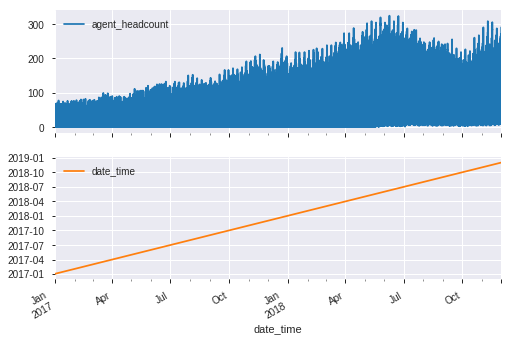

In [94]:
features_drop = ['total_calls', 'total_calls_duration', 'missing_calls', 'available_time', 'away_time', 'busy_time', 'on_a_call_time', 'after_call_work_time', 'total_handle_time', 'occupancy_rate', 'utilization_rate', 'shrinkage_rate']
hourly_ds_xy = hourly_ds_final.drop(features_drop, axis=1)
hourly_ds_xy.head()
hourly_ds_xy.plot(subplots=True)

In [95]:
df = hourly_ds_xy.reset_index(drop=True)
df.columns = ['y','ds']
df.head()
#df.plot(subplots=True)

y                  ds
0  58 2017-01-01 00:00:00
1  57 2017-01-01 01:00:00
2  47 2017-01-01 02:00:00
3  34 2017-01-01 03:00:00
4  24 2017-01-01 04:00:00

In [96]:
hourly_ds_xy.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2018-11-30 14:00:00', '2018-11-30 15:00:00',
               '2018-11-30 16:00:00', '2018-11-30 17:00:00',
               '2018-11-30 18:00:00', '2018-11-30 19:00:00',
               '2018-11-30 20:00:00', '2018-11-30 21:00:00',
               '2018-11-30 22:00:00', '2018-11-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=16776, freq=None)

In [97]:
#Prophet seasonality param for hours to forecast
pred_size_hour = 744 #31 x 24
train_dfw = df[:-pred_size_hour]


#m = Prophet(weekly_seasonality=True)
#m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#forecast_w = m.fit(train_dfw).predict(future)
#fig = m.plot_components(forecast_w)

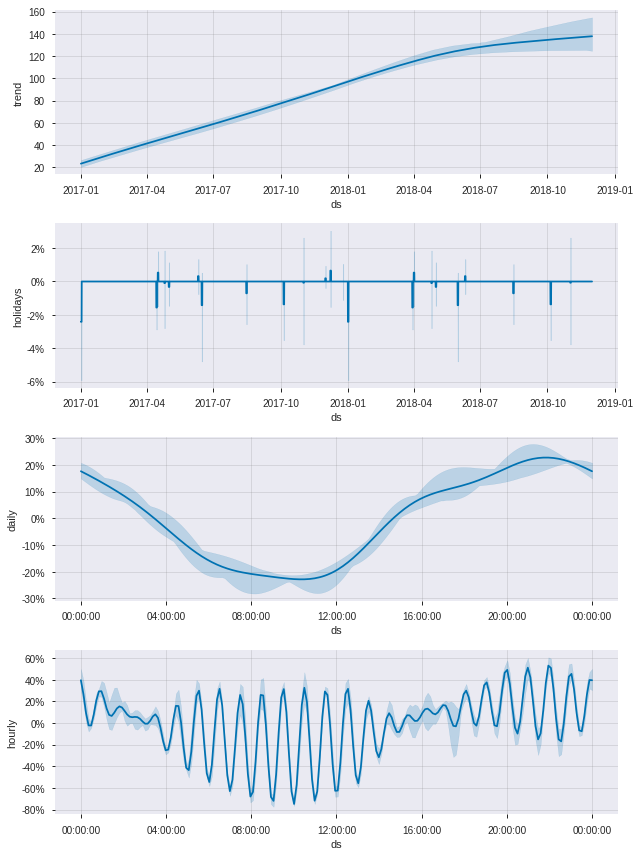

In [195]:
#After some exploration with the Holt-Winter forecasting method over this dataset in InfluxDB I found out 23 is a number very reasonable to explain the periods of the event in dataset

m_WWSeason = Prophet(weekly_seasonality=False, seasonality_mode='multiplicative',interval_width=0.80, mcmc_samples=30,uncertainty_samples=30, changepoint_prior_scale=0.01, changepoint_range=1.0)
m_WWSeason.add_seasonality(name='hourly', period=1, fourier_order=30, prior_scale=0.1)
m_WWSeason.add_country_holidays(country_name='PT')
m_WWSeason.fit(train_dfw)
future_WWseason = m_WWSeason.make_future_dataframe(periods=pred_size_hour, freq='H')
forecast_WWSeason = m_WWSeason.predict(future_WWseason)


fig_s = m_WWSeason.plot_components(forecast_WWSeason)

#https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
#The period input needs to be the length of the period in days. So, a seasonality over one day has period=1.
#https://facebook.github.io/prophet/docs/uncertainty_intervals.html
#https://facebook.github.io/prophet/docs/non-daily_data.html#sub-daily-data

In [196]:
withhour_comp_season = make_comparison(train_dfw, forecast_WWSeason)


In [198]:
#train_dfw
withhour_comp_season.tail(16)

yhat  yhat_lower  yhat_upper   y
ds                                                         
2018-11-30 08:00:00   13.226241  -16.476017   63.650892 NaN
2018-11-30 09:00:00    5.483948  -40.392367   44.642046 NaN
2018-11-30 10:00:00    3.070084  -28.537998   50.365238 NaN
2018-11-30 11:00:00    7.042113  -25.366100   45.866425 NaN
2018-11-30 12:00:00   20.013538  -34.665495   68.350350 NaN
2018-11-30 13:00:00   42.161754  -21.245902   87.469444 NaN
2018-11-30 14:00:00   87.194738   41.019851  130.851790 NaN
2018-11-30 15:00:00  131.706532   89.462698  195.084837 NaN
2018-11-30 16:00:00  159.260982  116.577650  201.266938 NaN
2018-11-30 17:00:00  174.807515  127.059511  215.081187 NaN
2018-11-30 18:00:00  193.879379  138.834941  252.105337 NaN
2018-11-30 19:00:00  211.188218  163.032263  271.428108 NaN
2018-11-30 20:00:00  232.453869  179.706563  266.226616 NaN
2018-11-30 21:00:00  238.133544  187.863343  297.024763 NaN
2018-11-30 22:00:00  244.317792  197.857548  308.799062 NaN
2018-11-30 23:00:00  231.074693  188.159566  291.969123 NaN

In [189]:
train_dfw.tail()

y                  ds
16027  208 2018-10-30 19:00:00
16028  217 2018-10-30 20:00:00
16029  211 2018-10-30 21:00:00
16030  210 2018-10-30 22:00:00
16031  208 2018-10-30 23:00:00

In [199]:
#Somehow the predict is not forecasting in hours.
forecast_WWSeason.tail(16)

ds       trend  yhat_lower  yhat_upper  trend_lower  \
16760 2018-11-30 08:00:00  137.753044  -16.476017   63.650892   124.781288   
16761 2018-11-30 09:00:00  137.755218  -40.392367   44.642046   124.777213   
16762 2018-11-30 10:00:00  137.757393  -28.537998   50.365238   124.773139   
16763 2018-11-30 11:00:00  137.759567  -25.366100   45.866425   124.769065   
16764 2018-11-30 12:00:00  137.761742  -34.665495   68.350350   124.764991   
16765 2018-11-30 13:00:00  137.763916  -21.245902   87.469444   124.760917   
16766 2018-11-30 14:00:00  137.766090   41.019851  130.851790   124.756843   
16767 2018-11-30 15:00:00  137.768265   89.462698  195.084837   124.752769   
16768 2018-11-30 16:00:00  137.770439  116.577650  201.266938   124.748694   
16769 2018-11-30 17:00:00  137.772614  127.059511  215.081187   124.744620   
16770 2018-11-30 18:00:00  137.774788  138.834941  252.105337   124.740546   
16771 2018-11-30 19:00:00  137.776963  163.032263  271.428108   124.736472   
16772 2018-11-30 20:00:00  137.779137  179.706563  266.226616   124.732398   
16773 2018-11-30 21:00:00  137.781312  187.863343  297.024763   124.728324   
16774 2018-11-30 22:00:00  137.783486  197.857548  308.799062   124.724250   
16775 2018-11-30 23:00:00  137.785661  188.159566  291.969123   124.720176   

       trend_upper  Ano Novo  Ano Novo_lower  Ano Novo_upper  \
16760   154.654883       0.0             0.0             0.0   
16761   154.660092       0.0             0.0             0.0   
16762   154.665301       0.0             0.0             0.0   
16763   154.670509       0.0             0.0             0.0   
16764   154.675718       0.0             0.0             0.0   
16765   154.680927       0.0             0.0             0.0   
16766   154.686135       0.0             0.0             0.0   
16767   154.691344       0.0             0.0             0.0   
16768   154.696553       0.0             0.0             0.0   
16769   154.701762       0.0             0.0             0.0   
16770   154.706970       0.0             0.0             0.0   
16771   154.712179       0.0             0.0             0.0   
16772   154.717388       0.0             0.0             0.0   
16773   154.722596       0.0             0.0             0.0   
16774   154.727805       0.0             0.0             0.0   
16775   154.733014       0.0             0.0             0.0   

       Assunção de Nossa Senhora  ...    hourly  hourly_lower  hourly_upper  \
16760                        0.0  ... -0.695724     -0.737445     -0.626117   
16761                        0.0  ... -0.741048     -0.785362     -0.691161   
16762                        0.0  ... -0.750167     -0.768420     -0.738697   
16763                        0.0  ... -0.724591     -0.754445     -0.690630   
16764                        0.0  ... -0.660221     -0.691034     -0.625921   
16765                        0.0  ... -0.561135     -0.591623     -0.519175   
16766                        0.0  ... -0.314926     -0.377467     -0.236247   
16767                        0.0  ... -0.067237     -0.122939      0.001339   
16768                        0.0  ...  0.080876      0.043965      0.130049   
16769                        0.0  ...  0.165028      0.144284      0.190265   
16770                        0.0  ...  0.282464      0.197997      0.338784   
16771                        0.0  ...  0.379942      0.352371      0.431098   
16772                        0.0  ...  0.498490      0.439301      0.582367   
16773                        0.0  ...  0.509880      0.416435      0.593193   
16774                        0.0  ...  0.545976      0.474812      0.630371   
16775                        0.0  ...  0.466377      0.407476      0.567916   

       multiplicative_terms  multiplicative_terms_lower  \
16760             -0.903986                   -0.921538   
16761             -0.960191                   -0.993266   
16762             -0.977714                   -0.995932   
16763             -0.948881

In [200]:
for err_name, err_value in calculate_forecast_err(withhour_comp_season, pred_size_hour).items():
    print(err_name, err_value)

MAPE nan
MAE nan


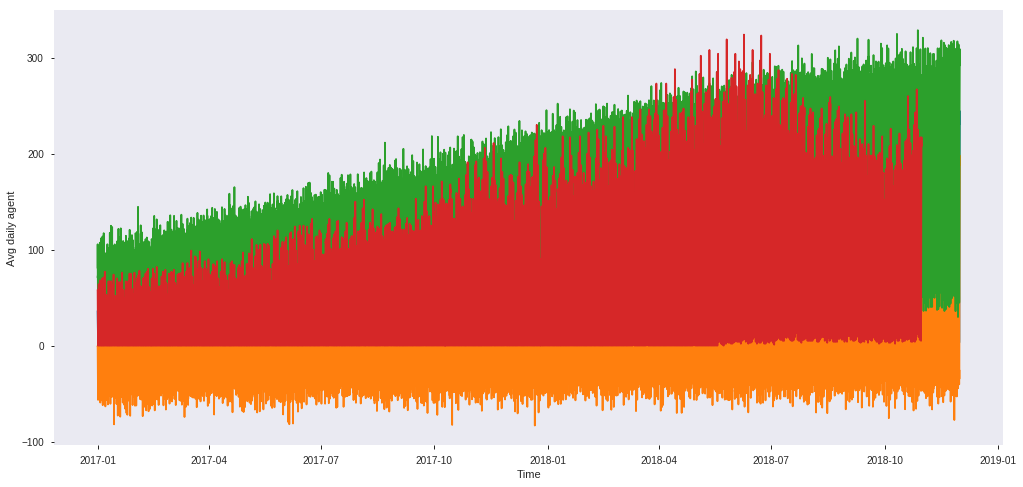

In [203]:
plt.figure(figsize=(17,8))
plt.plot(withhour_comp_season['yhat'])
plt.plot(withhour_comp_season['yhat_lower'])
plt.plot(withhour_comp_season['yhat_upper'])
plt.plot(withhour_comp_season['y'])
plt.xlabel('Time')
plt.ylabel('Avg daily agent')
plt.grid(False)
plt.show()

In [207]:
forecast_filter = forecast_WWSeason[(forecast_WWSeason['ds'] >= '2018-10-30 00:00:00') & (forecast_WWSeason['ds'] <= '2021-10-31 23:59:00')]

In [214]:
withhour_comp_season.head(18)

yhat  yhat_lower  yhat_upper     y
ds                                                          
2017-01-01 00:00:00  36.134005   -0.562887   80.734692  58.0
2017-01-01 01:00:00  32.434747   -0.238564  105.566379  57.0
2017-01-01 02:00:00  27.763765   -9.500948   71.718199  47.0
2017-01-01 03:00:00  23.370983  -24.536093   70.474438  34.0
2017-01-01 04:00:00  15.909744  -24.029305   72.821592  24.0
2017-01-01 05:00:00   9.903666  -36.918825   54.612991   6.0
2017-01-01 06:00:00   6.312080  -44.417794   69.245608   1.0
2017-01-01 07:00:00   3.607820  -45.013801   49.083193   0.0
2017-01-01 08:00:00   1.682393  -43.422773   48.607738   0.0
2017-01-01 09:00:00   0.366494  -48.677209   49.576160   0.0
2017-01-01 10:00:00  -0.043979  -56.565763   40.434895   0.0
2017-01-01 11:00:00   0.631870  -36.549750   57.542335   0.0
2017-01-01 12:00:00   2.840060  -36.429453   70.421947   0.0
2017-01-01 13:00:00   6.612420  -54.287620   54.334662   0.0
2017-01-01 14:00:00  14.285603  -25.905457   56.534262   5.0
2017-01-01 15:00:00  21.875389  -25.865828   75.473568  14.0
2017-01-01 16:00:00  26.579995  -23.159241   81.169493  24.0
2017-01-01 17:00:00  29.240336  -21.731353   80.602656  32.0

In [210]:
#forecast_WWSeason['yhat'] = forecast_WWSeason['yhat'].apply(lambda row: row if row>=0 else 0)
#forecast_filter.head(16)
#forecast_WWSeason.head(16)
#forecast_filter.head(16)

forecast_filter['yhat'] = forecast_filter['yhat'].apply(lambda x: round(x, 1))


In [211]:
forecast_filter.head(16)


ds       trend  yhat_lower  yhat_upper  trend_lower  \
16008 2018-10-30 00:00:00  136.117195  166.885966  264.829336   125.366470   
16009 2018-10-30 01:00:00  136.119398  136.478096  235.685852   125.366626   
16010 2018-10-30 02:00:00  136.121601  116.084964  228.305718   125.366783   
16011 2018-10-30 03:00:00  136.123804  101.855416  190.779208   125.366940   
16012 2018-10-30 04:00:00  136.126006   58.350694  157.892468   125.367096   
16013 2018-10-30 05:00:00  136.128209    9.366864  105.951435   125.367253   
16014 2018-10-30 06:00:00  136.130412   -4.976200   75.462501   125.367410   
16015 2018-10-30 07:00:00  136.132615  -23.963067   79.153463   125.367566   
16016 2018-10-30 08:00:00  136.134818  -22.816770   61.897208   125.367723   
16017 2018-10-30 09:00:00  136.137021  -40.548193   58.235407   125.367880   
16018 2018-10-30 10:00:00  136.139223  -47.261997   51.906321   125.368036   
16019 2018-10-30 11:00:00  136.141426  -20.249925   69.769605   125.368193   
16020 2018-10-30 12:00:00  136.143629  -16.464474   73.979164   125.368349   
16021 2018-10-30 13:00:00  136.145832  -15.828610  122.291897   125.368506   
16022 2018-10-30 14:00:00  136.148035   22.421397  140.313768   125.368663   
16023 2018-10-30 15:00:00  136.150238   91.393722  193.004779   125.368819   

       trend_upper  Ano Novo  Ano Novo_lower  Ano Novo_upper  \
16008   150.666911       0.0             0.0             0.0   
16009   150.672933       0.0             0.0             0.0   
16010   150.678955       0.0             0.0             0.0   
16011   150.684977       0.0             0.0             0.0   
16012   150.690999       0.0             0.0             0.0   
16013   150.697021       0.0             0.0             0.0   
16014   150.703044       0.0             0.0             0.0   
16015   150.709066       0.0             0.0             0.0   
16016   150.715088       0.0             0.0             0.0   
16017   150.721110       0.0             0.0             0.0   
16018   150.727132       0.0             0.0             0.0   
16019   150.733155       0.0             0.0             0.0   
16020   150.739177       0.0             0.0             0.0   
16021   150.745199       0.0             0.0             0.0   
16022   150.751221       0.0             0.0             0.0   
16023   150.757243       0.0             0.0             0.0   

       Assunção de Nossa Senhora  ...    hourly  hourly_lower  hourly_upper  \
16008                        0.0  ...  0.395658      0.303199      0.501111   
16009                        0.0  ...  0.279350      0.223959      0.393906   
16010                        0.0  ...  0.127040      0.061242      0.203647   
16011                        0.0  ... -0.004539     -0.066855      0.043697   
16012                        0.0  ... -0.258077     -0.295317     -0.240114   
16013                        0.0  ... -0.448504     -0.487912     -0.409976   
16014                        0.0  ... -0.548302     -0.572519     -0.501560   
16015                        0.0  ... -0.630515     -0.674237     -0.591556   
16016                        0.0  ... -0.695724     -0.737445     -0.626117   
16017                        0.0  ... -0.741048     -0.785362     -0.691161   
16018                        0.0  ... -0.750167     -0.768420     -0.738697   
16019                        0.0  ... -0.724591     -0.754445     -0.690630   
16020                        0.0  ... -0.660221     -0.691034     -0.625921   
16021                        0.0  ... -0.561135     -0.591623     -0.519175   
16022                        0.0  ... -0.314926     -0.377467     -0.236247   
16023                        0.0  ... -0.067237     -0.122939      0.001339   

       multiplicative_terms  multiplicative_terms_lower  \
16008              0.571937                    0.511111   
16009              0.412968                    0.354490   
16010              0.212523                    0.189847   
16011              0.024131

In [158]:
#https://facebook.github.io/prophet/docs/non-daily_data.html#sub-daily-data
#https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-prophet/


In [212]:
forecast_filter.to_csv("submission_final.csv", index = False, sep=',', encoding='utf-8', columns=['ds','yhat'])

In [ ]:
forecast.head(48)

## Forecasting with influxDB time steps in Hour interval using holt-winter

https://influxdb-python.readthedocs.io/en/latest/examples.html

In [1]:
##https://docs.influxdata.com/influxdb/v1.7/query_language/functions/#holt-winters
!python -m pip install influxdb
from influxdb import InfluxDBClient

pwd = "tiagoooliveira"
usr = "tiagoooliveira"

In [2]:
client = InfluxDBClient("localhost", "8086", usr, pwd, "phonecall")


In [4]:
#Let's assume that the "InfluxCallsLogInsert.py" python script has been executed previously, so the calls dataset is stored in the phonecall InfluxDB database/calls_hour table

#Holt-Winters seasonality param for hours to forecast
pred_size_hour = 744 #31 x 24 :: Hours x Days
#time period events
period = 23

query = 'SELECT HOLT_WINTERS_WITH_FIT(FIRST("agent_headcount"),' + str(pred_size_hour) + ',' + str(period) + ') from phonecall.autogen.calls_hour GROUP BY time(1h) LIMIT 10'

result = client.query(query)

print("Result: {0}".format(result))


SELECT HOLT_WINTERS_WITH_FIT(LAST("agent_headcount"),744,23) from phonecall.autogen.calls_hour GROUP BY time(1h) LIMIT 10
Result: ResultSet({'('calls_hour', None)': [{'time': '2017-01-01T00:00:00Z', 'holt_winters_with_fit': 58}, {'time': '2017-01-01T01:00:00Z', 'holt_winters_with_fit': 54.72135645382322}, {'time': '2017-01-01T02:00:00Z', 'holt_winters_with_fit': 28.201991281916698}, {'time': '2017-01-01T03:00:00Z', 'holt_winters_with_fit': 26.61528886039476}, {'time': '2017-01-01T04:00:00Z', 'holt_winters_with_fit': 26.638596571791826}, {'time': '2017-01-01T05:00:00Z', 'holt_winters_with_fit': 26.649532857161944}, {'time': '2017-01-01T06:00:00Z', 'holt_winters_with_fit': 26.655014669960973}, {'time': '2017-01-01T07:00:00Z', 'holt_winters_with_fit': 55.36118824703627}, {'time': '2017-01-01T08:00:00Z', 'holt_winters_with_fit': 26.659310141538633}, {'time': '2017-01-01T09:00:00Z', 'holt_winters_with_fit': 55.3658433595945}]})


In [ ]:
#A sample collected from holt-winter forecasting
###
#2018-11-30T10:00:00Z 29.050821283924837
#2018-11-30T11:00:00Z 61.25457641819887
#2018-11-30T12:00:00Z 29.050821283924837
#2018-11-30T13:00:00Z 61.25457641819887
#2018-11-30T14:00:00Z 61.254576418198894
#2018-11-30T15:00:00Z 61.25457641819889
#2018-11-30T16:00:00Z 61.25457641819889
#2018-11-30T17:00:00Z 30.83219556861576
#2018-11-30T18:00:00Z 29.050821283924837
#2018-11-30T19:00:00Z 29.050821283924837
#2018-11-30T20:00:00Z 29.050821283924837
#2018-11-30T21:00:00Z 29.050821283924837
#2018-11-30T22:00:00Z 61.25457641819887
#2018-11-30T23:00:00Z 29.050821283924837
#2018-12-01T00:00:00Z 61.25457641819888
#2018-12-01T01:00:00Z 29.050821283924837
#2018-12-01T02:00:00Z 29.050821283924837
#2018-12-01T03:00:00Z 61.25457641819887
#2018-12-01T04:00:00Z 61.25457641819887
#2018-12-01T05:00:00Z 29.050821283924837
#2018-12-01T06:00:00Z 29.050821283924837
#2018-12-01T07:00:00Z 61.25457641819888
#2018-12-01T08:00:00Z 61.25457641819887

## Forecasting with TensorFlow time steps in Hour

## Spark MLlib

In [ ]:
#PySpark + SQL https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html
#Scala + SQL https://spark.apache.org/docs/2.4.0/sql-getting-started.html

## PySpark Koala
https://databricks.com/blog/2019/10/09/democratizing-financial-time-series-analysis-with-databricks.html
https://www.tutorialspoint.com/pyspark/pyspark_rdd.htm

conda install koalas -c conda-forge

https://www.tutorialspoint.com/pyspark/pyspark_rdd.htm

In [ ]:
!python -m pip install koalas

    100% |████████████████████████████████| 471kB 159kB/s 
    100% |████████████████████████████████| 60.5MB 159kB/s 


In [ ]:
#https://towardsdatascience.com/pyspark-feature-engineering-p1-f55cbd2b7565
#https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html

from numpy.random import randint
import findspark
findspark.init()

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.context import SparkContext
from pyspark.sql.types import *
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)